In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from copy import deepcopy
import mnist
import random
#For calculation of classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from scipy.ndimage import interpolation

In [ ]:
!pip install mnist

In [ ]:
# try:
#     from brian2 import *
# except ImportError:
#     !pip install brian2

## Integrate-and-fire neuron model

This is one of the simplest models of neuron behavior. It omits all the intricacies of what goes on electrochemically inside the neuron's body, and simply attempts to capture the basic 'accumulate till a threshold and then fire and let go of all the accumulation' aspect of a neuron's activity 

$$\frac{dv}{dt} = \frac{(v_0 - v)}{\tau},$$

where $v$ is the membrane voltage of the neuron, and $\tau$ is a timescale factor.

In [ ]:
v0 = 1
tau = 10*ms
eqs = '''
dv/dt = (v0-v)/tau : 1
'''

In [ ]:
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')
M = StateMonitor(G, 'v', record=True)
spikemon = SpikeMonitor(G)

In [ ]:
run(100*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')

## Hopfield network model

In this simplified Hopfied model, each neuron can only take values +1 or -1. The network stores pixel patterns, and attempts to retrieve them given some cue in the form of a part of the original pattern used to set an initial state $S_i(t=0)$ for every neuron in the network. The network activation of all the neurons evolves as follows

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right), $$

where the weight of every synaptic connection is calculated as,

$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where in turn, $N$ is the number of neurons, and $p_i^\mu$ is the state of the $i^{th}$ neuron for encoding pattern $\mu$.

The code below is taken from this [link](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html). Follow the accompanying exercises to be better prepared for your assignment. Remember to install all needed libraries before trying to run it. 

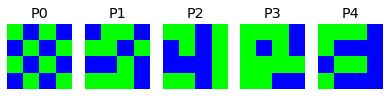

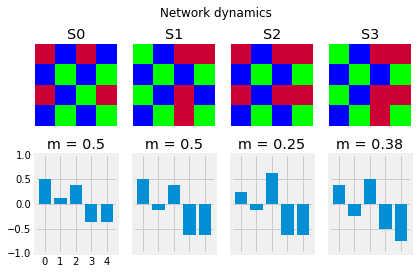

In [4]:
%matplotlib inline
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

pattern_size = 4

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=4, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)
# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
#plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=4)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=3)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")


## Our own Hopfield network model

You will write your own code to build a Hopfield network. I am leaving sample expected results below as a guide. 

In [ ]:
plist = get_patterns(4,5)
#plot_tools.plot_pattern_list(plist)

cue = deepcopy(plist)

S = perturb_pattern(cue[0],3)
wghts = calculate_weights(plist, pattern_size)

state_list =[S]
#state_list.append(S)
#print(state_list)
#plot_tools.plot_pattern(S)
for i in range(3):
    state_list.append(network_evolution(S,wghts))
#    state_list.append(S)

plot_tools.plot_pattern_list(plist)
#print(state_list[0])
plot_tools.plot_pattern(state_list[0])
plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle="Network dynamics")

## Assignment 1

Q1. Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)

Q2. Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of 
(a) the informativeness of the cue
(b) the number of other patterns stored in the network
(c) the size of the network

Present your answers with plots and/or math. (20 points)

Q3. Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation? (20 points)

Q4. Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points) 

**get_patterns(dim, num_patterns):-** Creates **num_patterns** number of square patterns of shape **dim*dim**

In [25]:
def get_patterns(dim, num_patterns):
    plist=[]
    for i in range(num_patterns):
        patt=np.random.choice([-1,1],dim*dim,p=[0.5,0.5])
       
       
        
        plist.append(patt) #Generates pattern of -1's and 1's of size dim*dim
    
    return plist

**perturb_pattern(ref, flips):-** Function which returns a random pattern by taking as input a reference image pattern **ref**, and flipping exactly **flips** random bits from +1->-1 or vice versa.

In [24]:
def perturb_pattern(ref, flips):
  
    N=ref.shape[0] #dimension of each pattern or number of neurons required for encoding
    flip_idx=np.random.choice(N, flips, replace=False)
    ref_flattened=ref.flatten()
    ref_flattened[flip_idx]=-ref_flattened[flip_idx]
    return ref_flattened

**calculate_weights(plist, N):-** Returns a weight matrix(denoted by $ w $ and represents the relationship between each pixel of the training image), computed by the following formula:-
$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where:- <br>
$\mu$= index number of a pattern present in **plist**<br>
$ w_{ij} $ indicates connection weight b/w neuron i and j, <br>
**N**= Dimension of each pattern<br>
**plist**= Number of patterns

In [23]:
def calculate_weights(plist, N):
    P=len(plist) #number of patterns
    w=np.zeros((N,N)) #Initializing weight matrix with all zeroes and dimensions N*N, where N=dimension of patterns
    plist=np.array(plist)
    w_vec=np.matmul(plist.T,plist)/N
    np.fill_diagonal(w_vec,0)
   
    return w_vec
    

**network_evolution(S_0, wghts):-** Takes in a state **S_0** and returns the following state, denoted by **S_1** after successfull updation of each node in the graph according to the following rule:-

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right) $$

In [26]:
def network_evolution(S_0,wghts):
   
   
    S_1=np.sign(np.matmul(wghts, S_0))
    
    
    S_1[S_1==0]=1
  
    return S_1

In [72]:
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

def train_hopfield(pattern_size, num_of_patterns, iterations, flip_patterns, ref_pattern):
   

    plist = get_patterns(pattern_size,num_of_patterns) #get_patterns(dimension of pattern, number of such patterns)

    #plot_tools.plot_pattern_list(plist)

    cue = deepcopy(plist)

    S = perturb_pattern(cue[ref_pattern],flip_patterns) #perturb_pattern(reference pattern, number of pixels to flip)

    wghts = calculate_weights(plist, pattern_size**2)
    

    state_list =[S]
    #state_list.append(S)
    #print(state_list)
    #plot_tools.plot_pattern(S)
    for i in range(1,iterations):
        state_list.append(network_evolution(state_list[i-1],wghts))
#    state_list.append(S)

    for i in range(num_of_patterns):
        plist[i]=plist[i].reshape(pattern_size,pattern_size)
    
    
    for i in range(iterations):
        
        state_list[i]=state_list[i].reshape(pattern_size,pattern_size)
    plot_tools.plot_pattern_list(plist)
#print(state_list[0])
    plot_tools.plot_pattern(state_list[0])
    plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=ref_pattern, suptitle="Network dynamics")
    
    return pattern_tools.compute_overlap_list(state_list[-1], plist)[ref_pattern]



### Informativeness of the cue:-

Informativeness of the cue can be attributed to flipping of pixels/bits, or we can say more we flip the bits, further we stray away from our reference pattern.

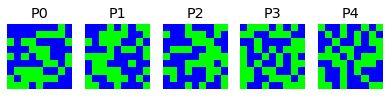

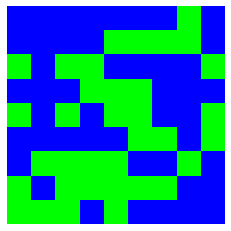

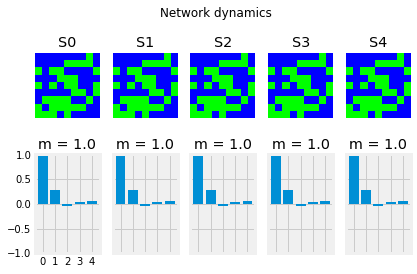

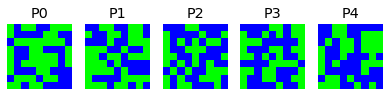

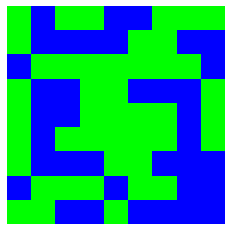

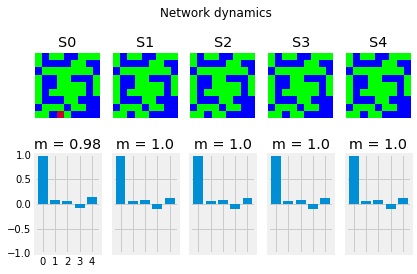

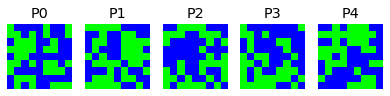

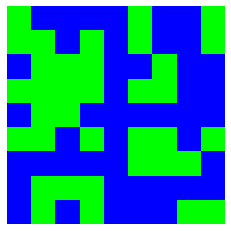

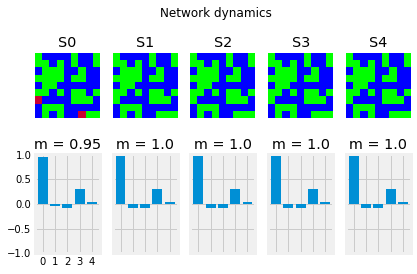

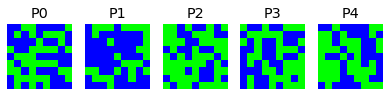

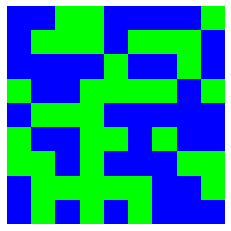

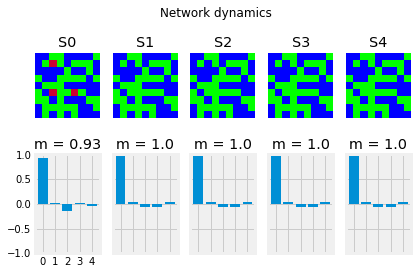

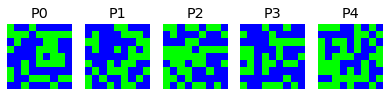

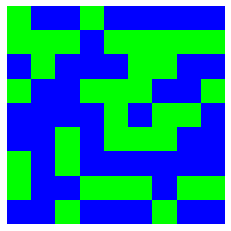

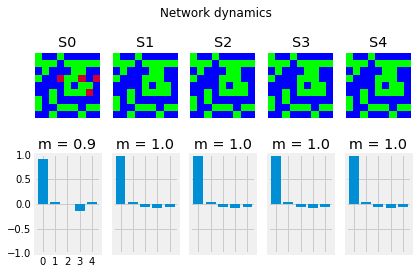

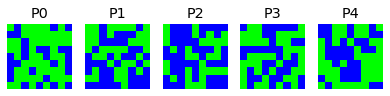

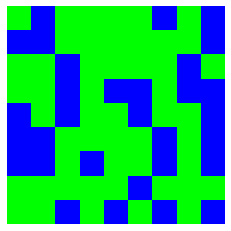

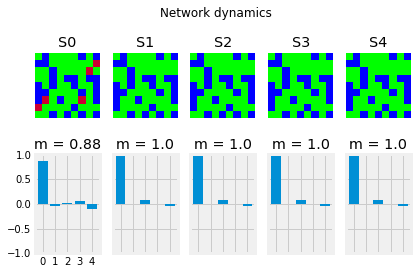

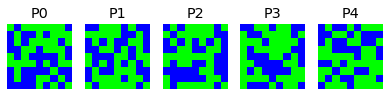

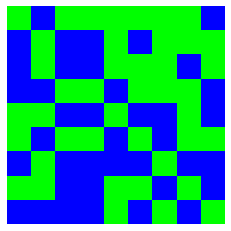

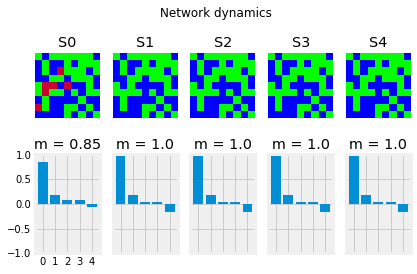

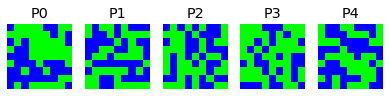

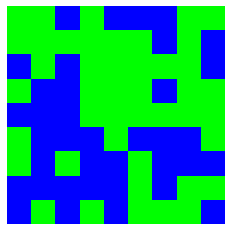

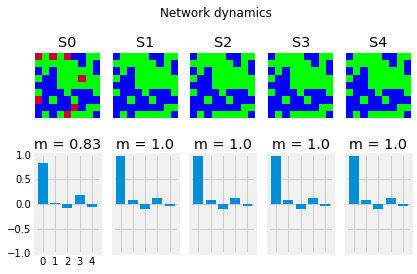

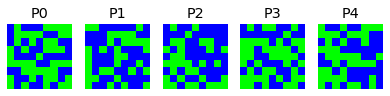

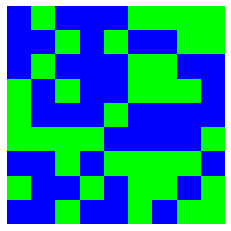

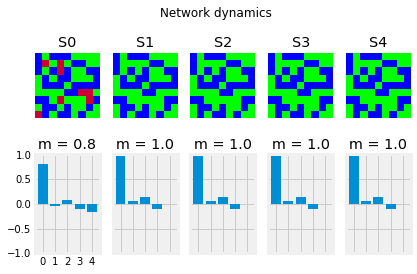

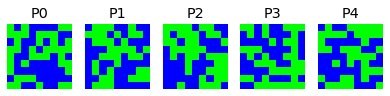

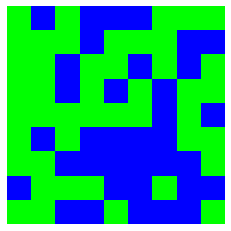

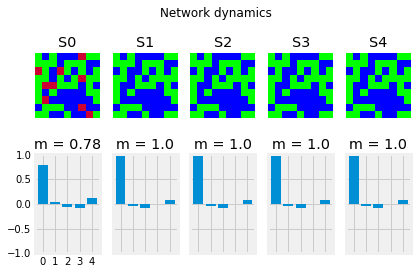

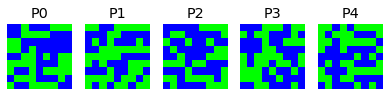

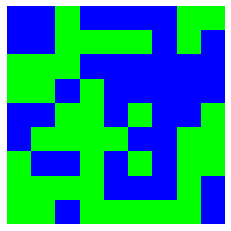

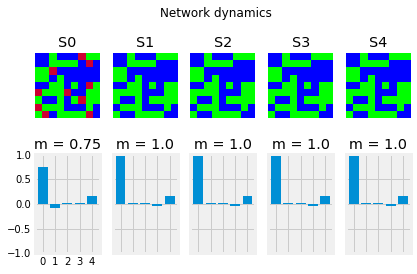

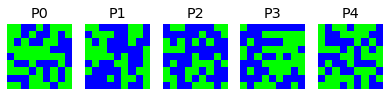

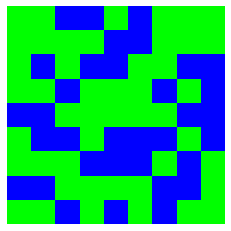

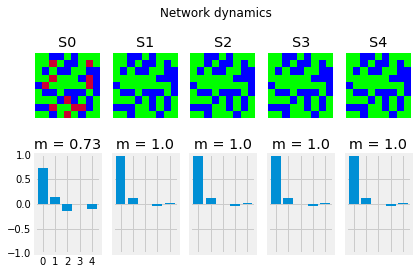

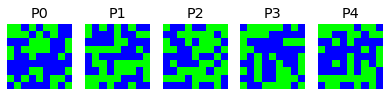

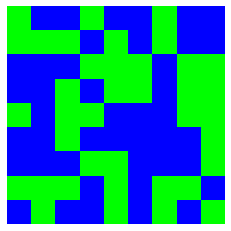

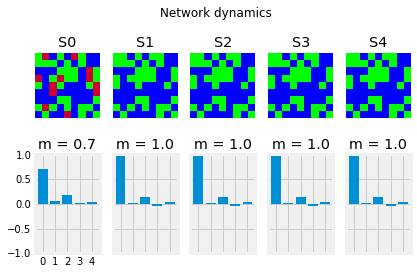

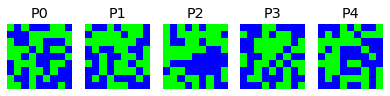

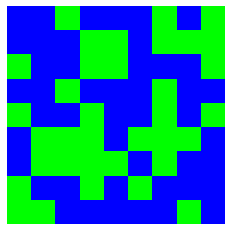

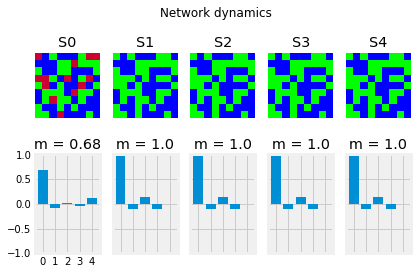

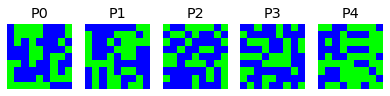

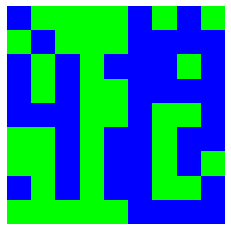

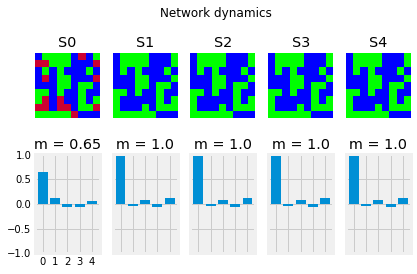

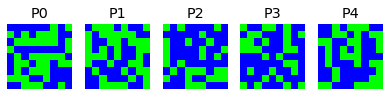

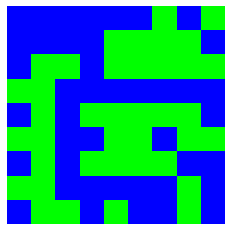

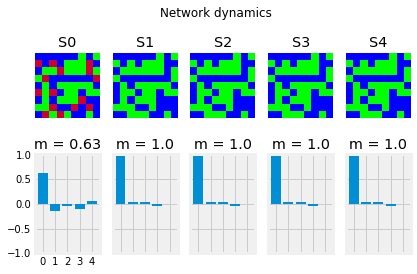

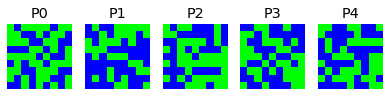

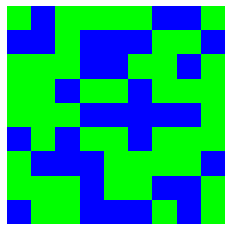

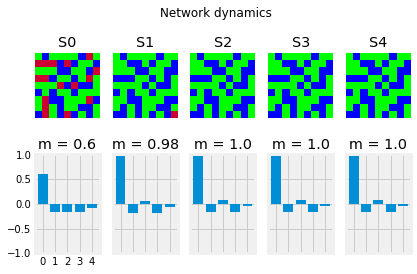

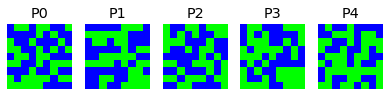

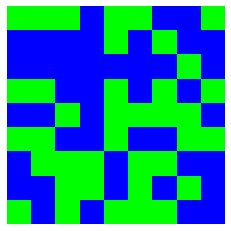

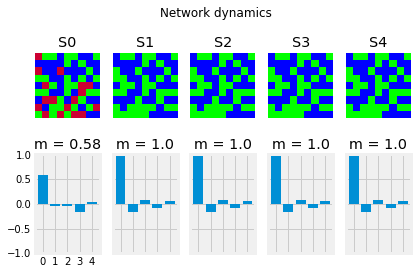

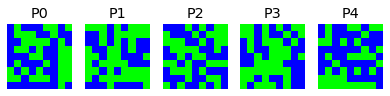

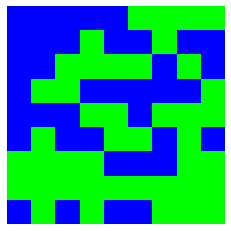

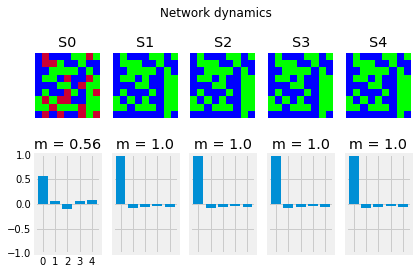

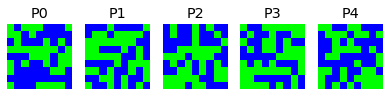

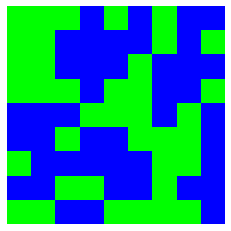

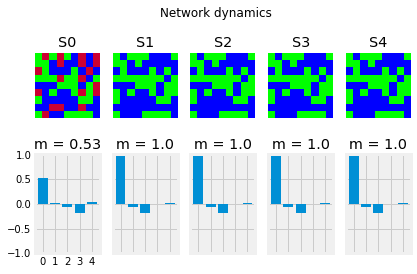

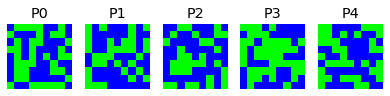

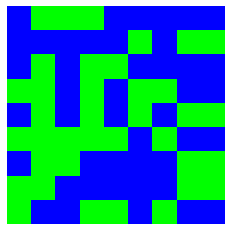

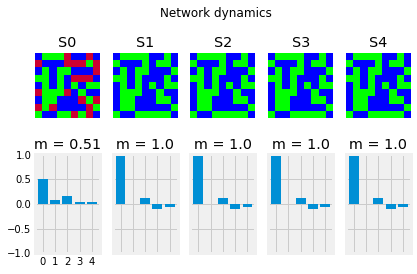

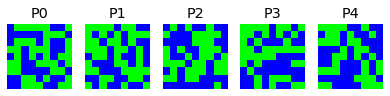

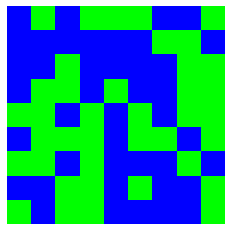

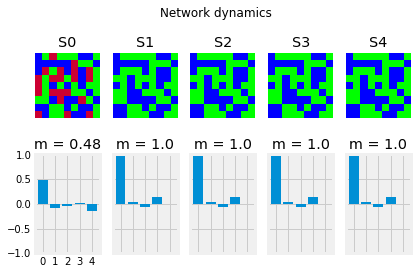

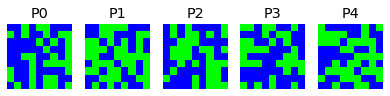

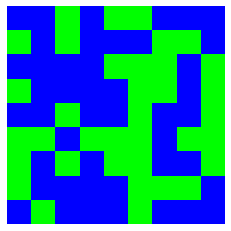

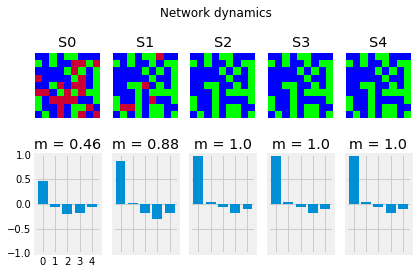

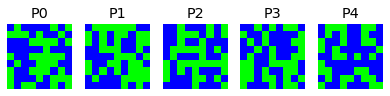

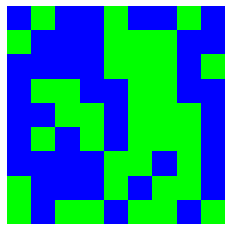

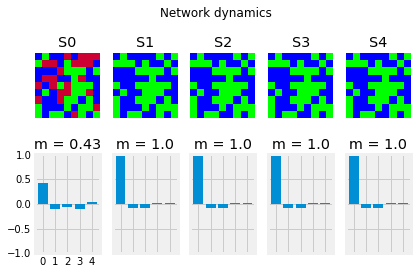

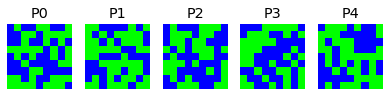

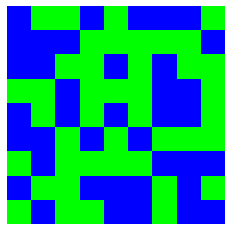

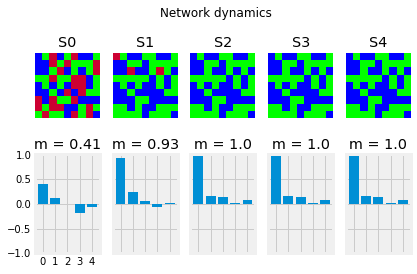

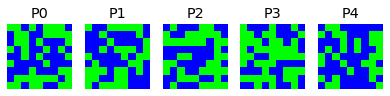

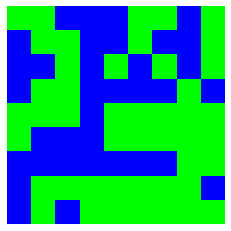

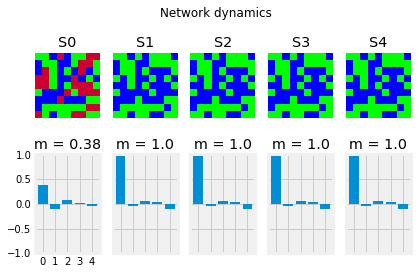

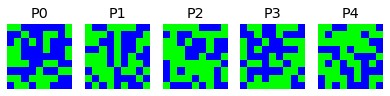

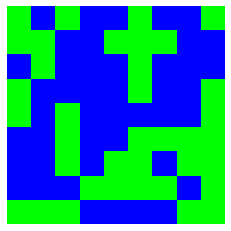

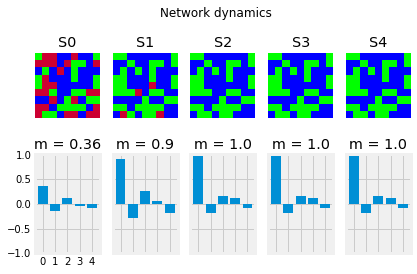

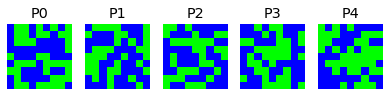

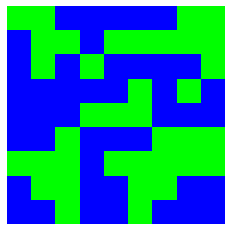

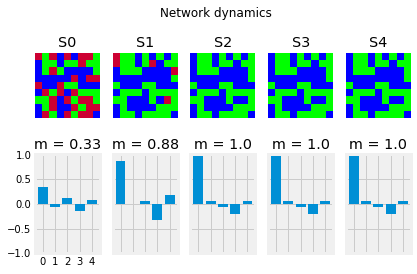

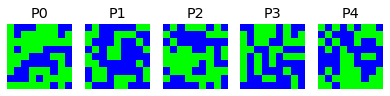

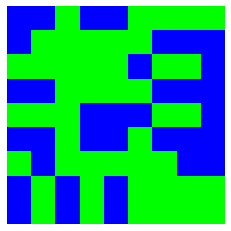

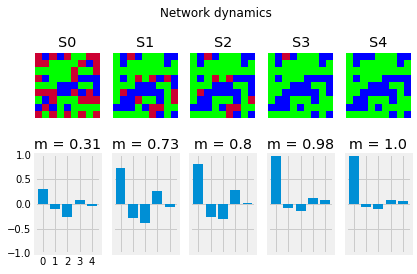

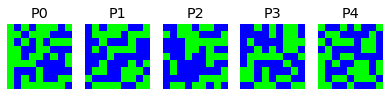

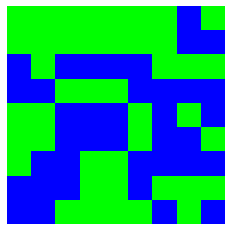

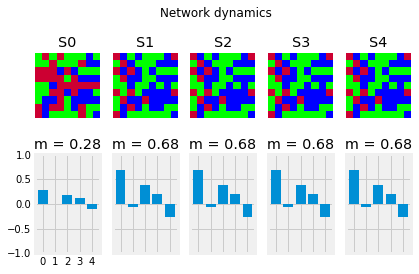

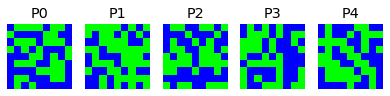

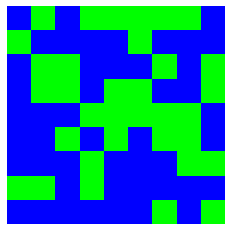

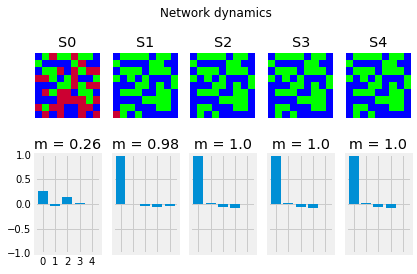

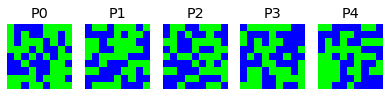

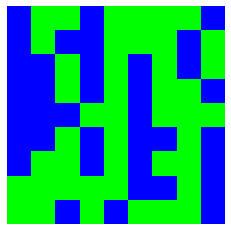

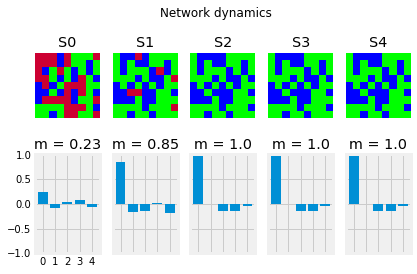

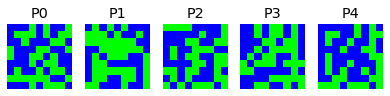

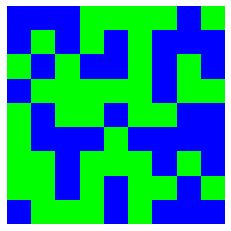

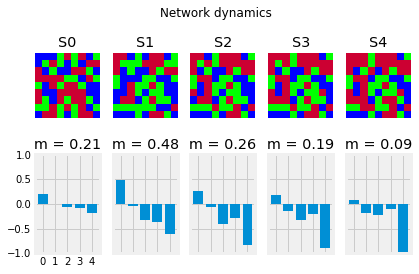

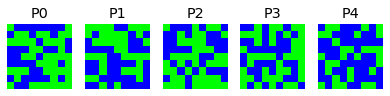

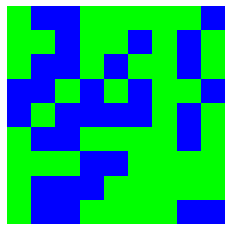

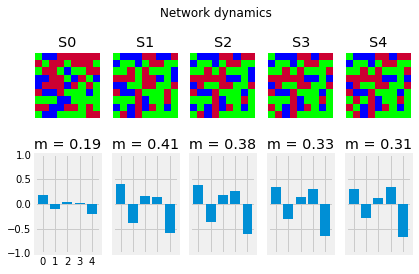

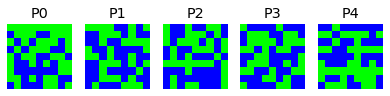

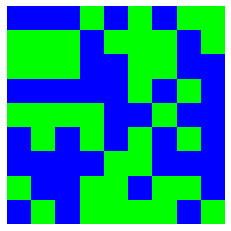

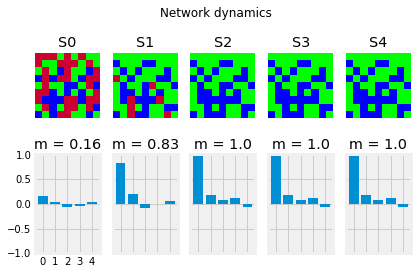

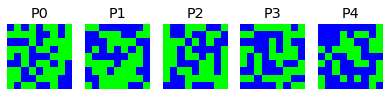

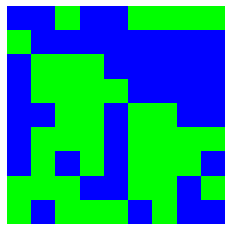

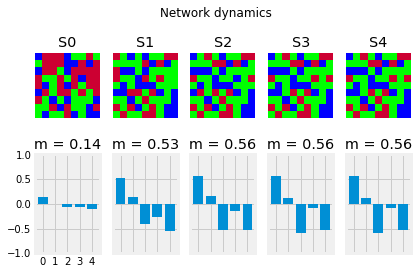

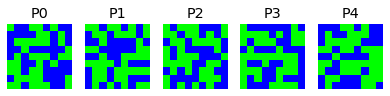

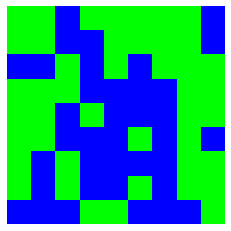

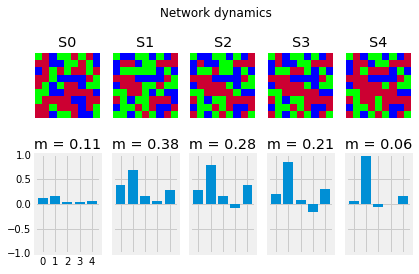

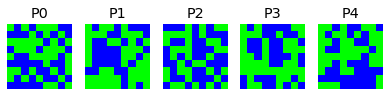

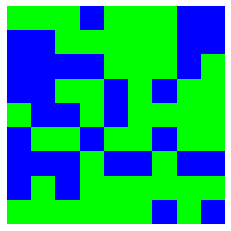

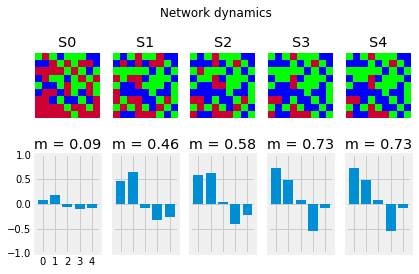

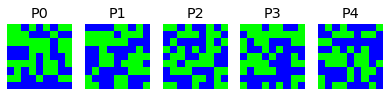

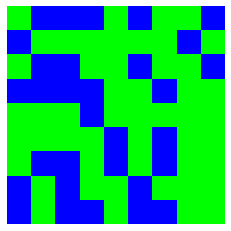

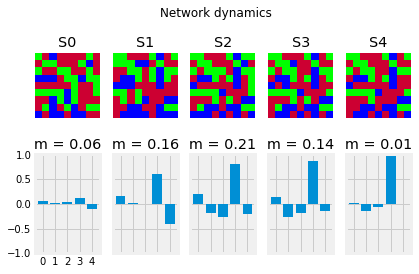

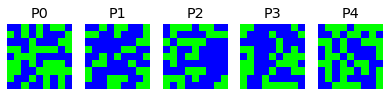

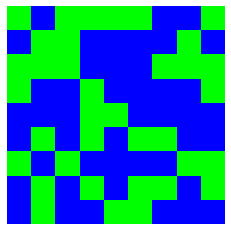

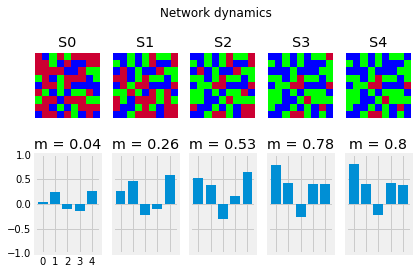

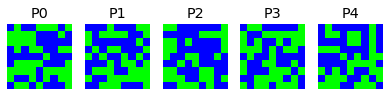

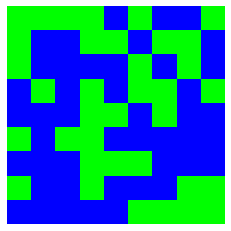

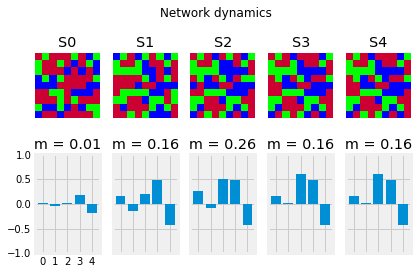

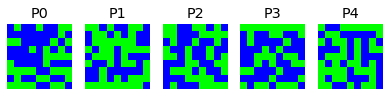

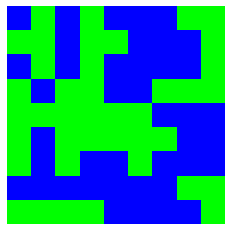

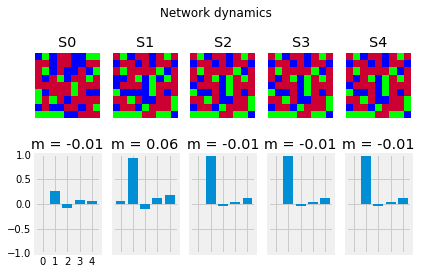

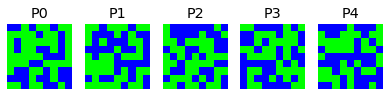

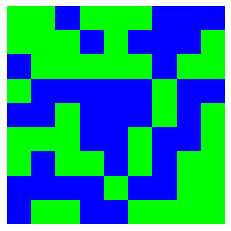

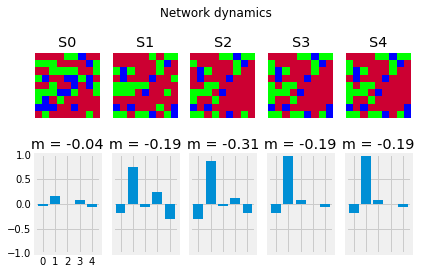

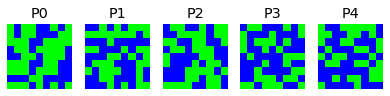

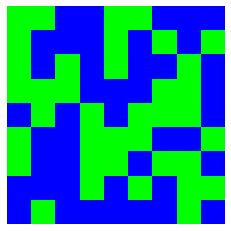

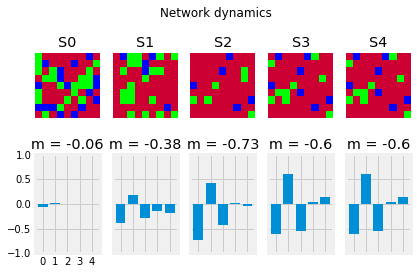

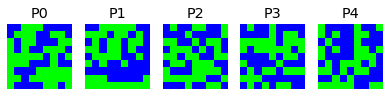

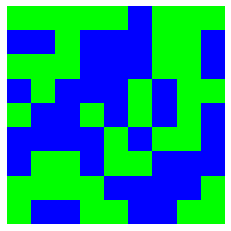

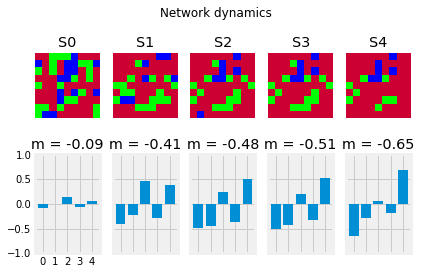

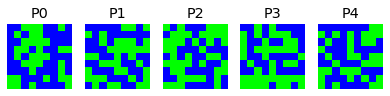

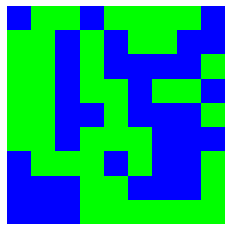

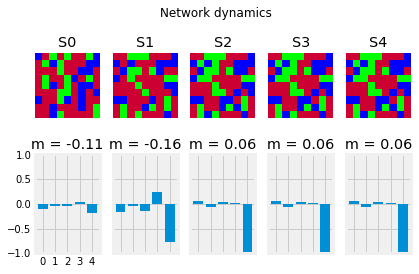

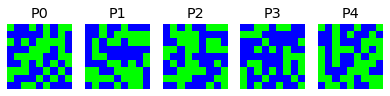

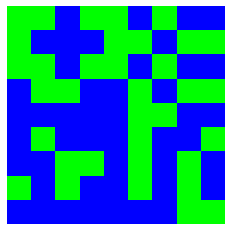

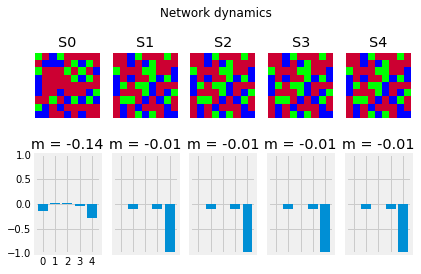

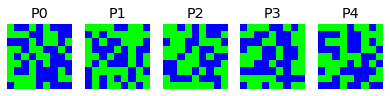

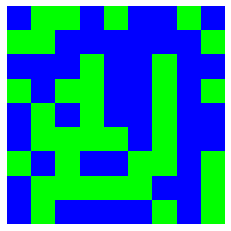

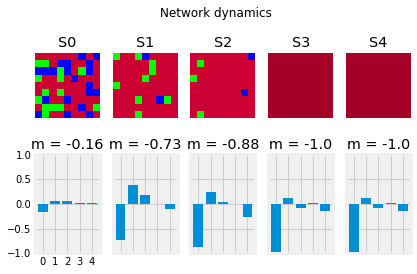

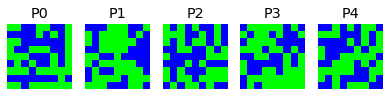

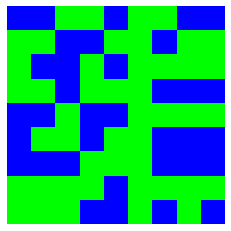

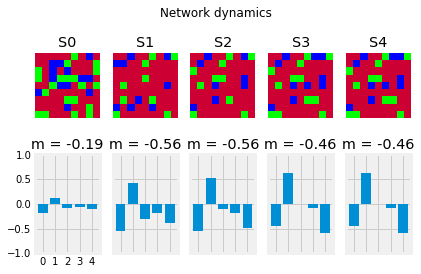

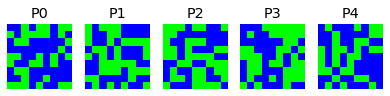

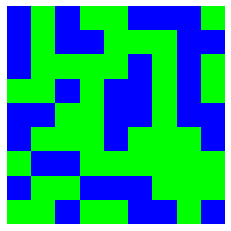

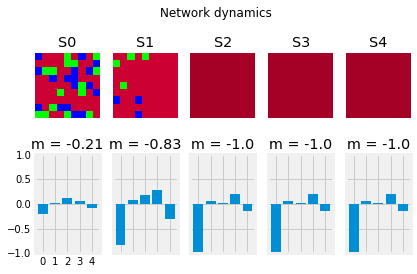

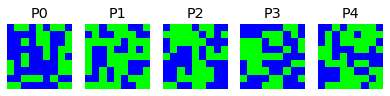

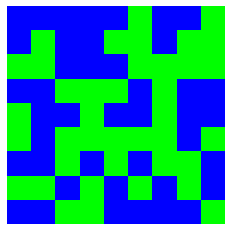

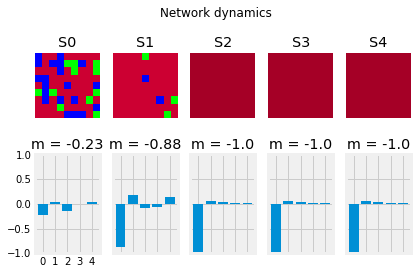

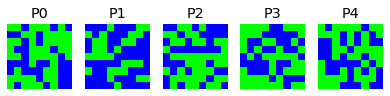

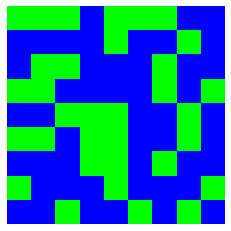

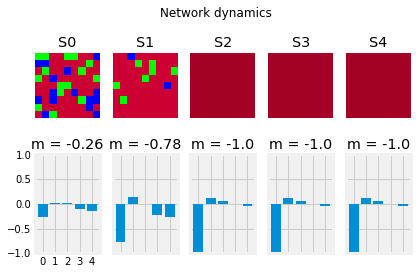

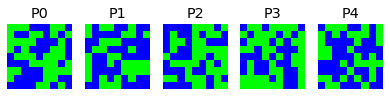

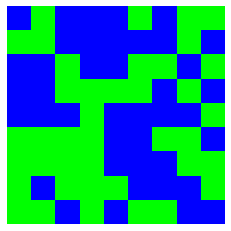

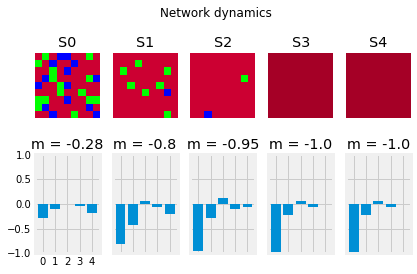

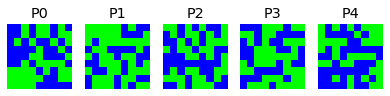

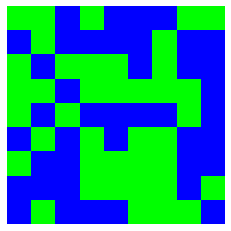

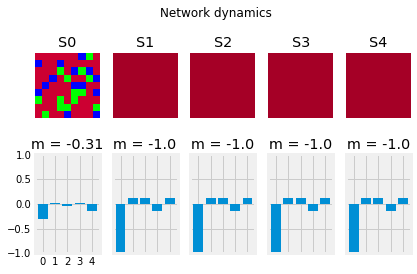

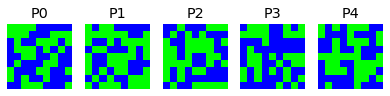

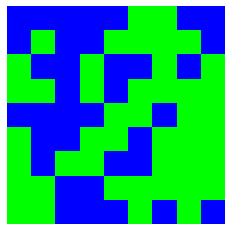

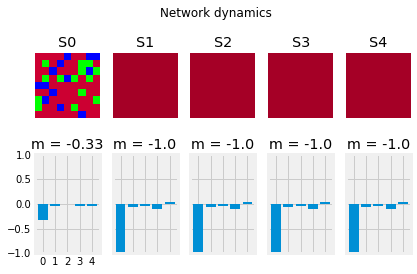

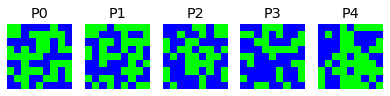

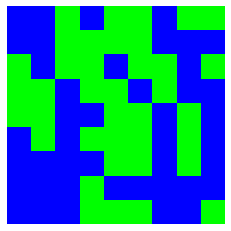

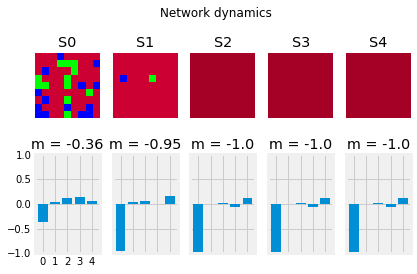

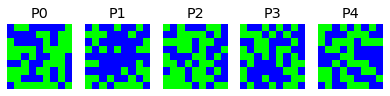

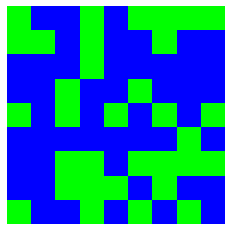

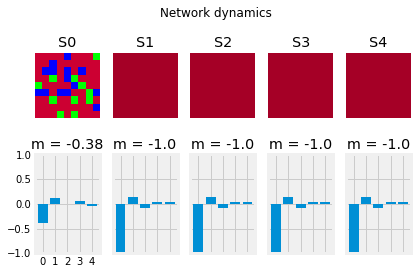

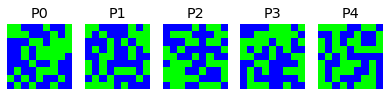

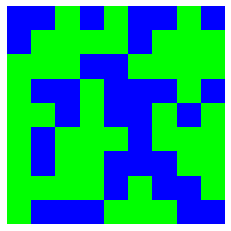

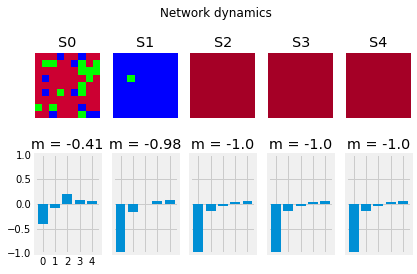

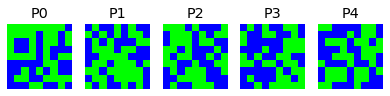

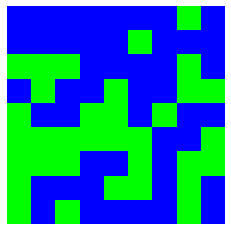

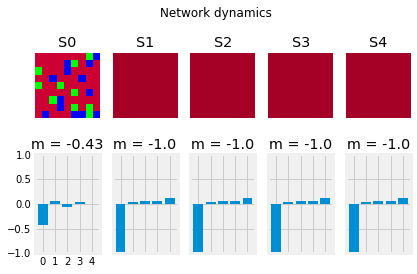

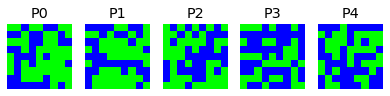

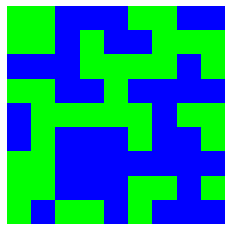

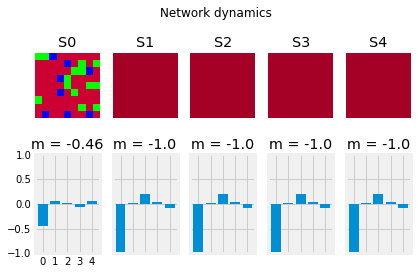

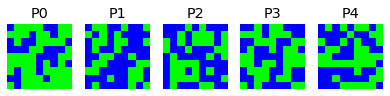

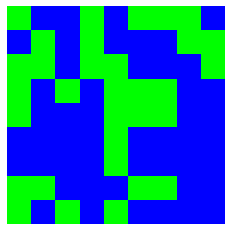

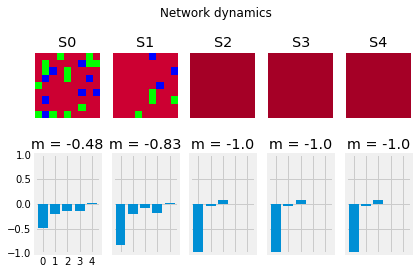

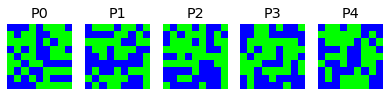

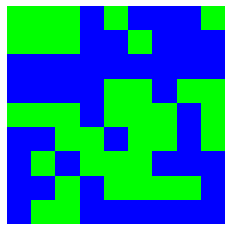

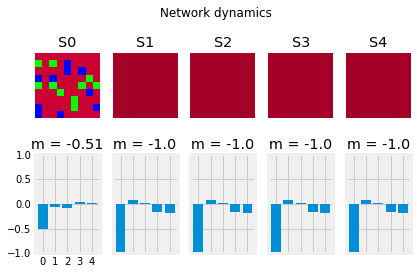

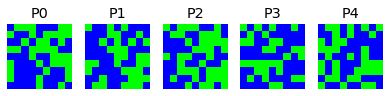

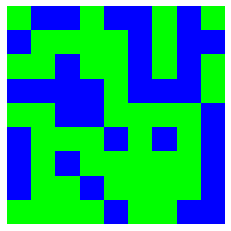

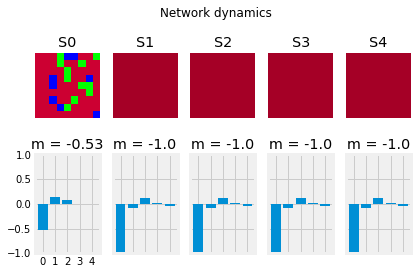

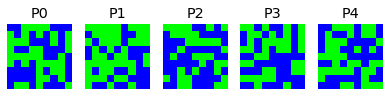

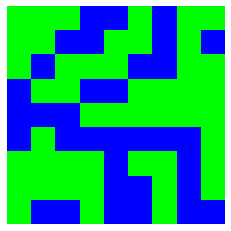

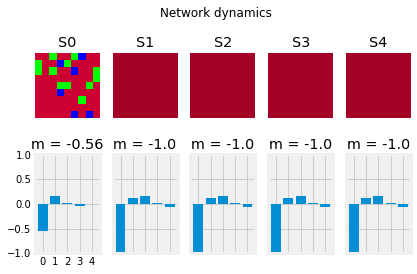

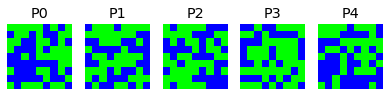

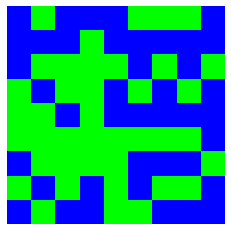

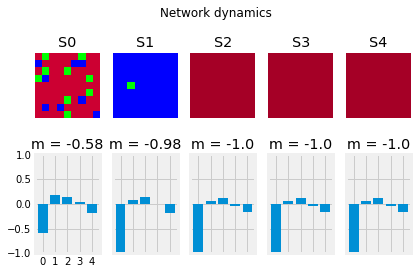

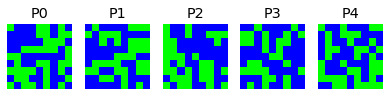

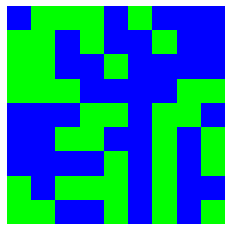

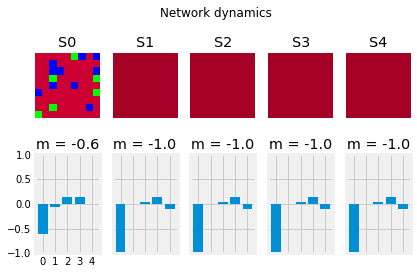

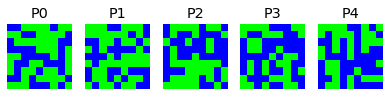

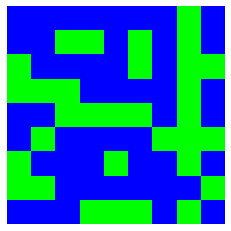

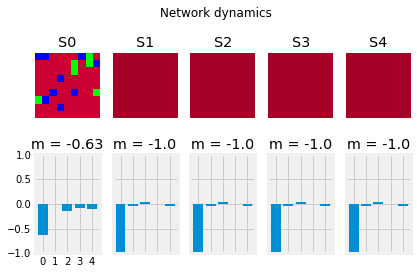

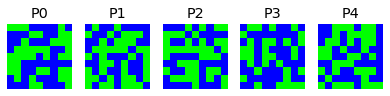

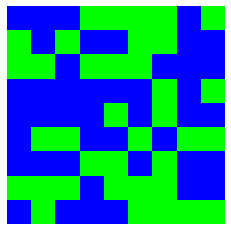

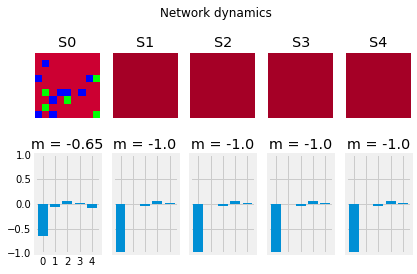

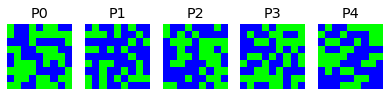

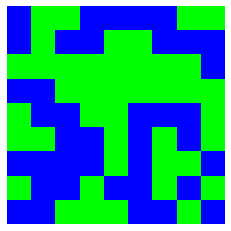

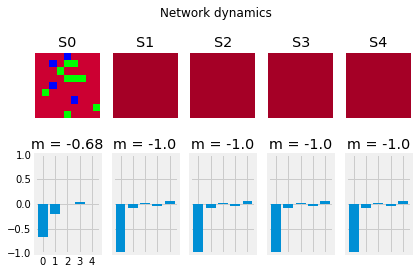

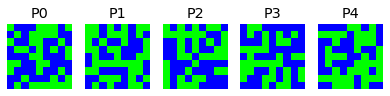

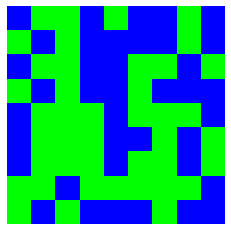

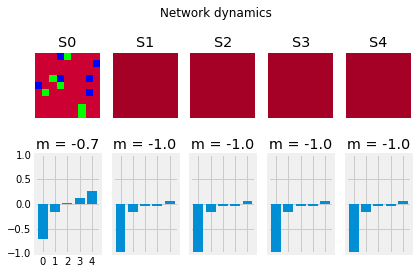

In [73]:
flip_patterns_list=list(range(70))
overlap_corr=[]
for patt in flip_patterns_list:
    overlap_corr.append(train_hopfield(9, 5, 5, patt, 0))



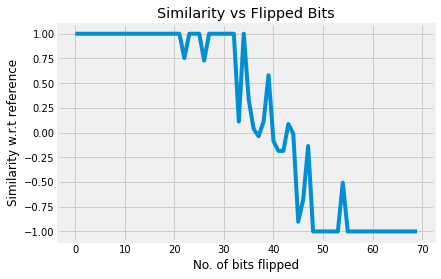

In [60]:
plt.plot(flip_patterns_list, overlap_corr)
plt.xlabel('No. of bits flipped')
plt.ylabel('Similarity w.r.t reference')
plt.title('Similarity vs Flipped Bits')
plt.show()

### Insights drawn from the above graph

The model behaves as expected, the more we move away from the reference pattern, the harder it becomes for the model to find the original pattern amongnst all the noise. This happens as we're storing the association b/w neurons in a compact format in the matrix, and as we flip more bits the association becomes weaker with the original image and it becomes increasingly difficult to reproduce the original pattern.


### Number of patterns Stored:-



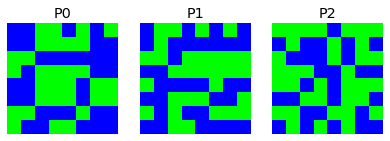

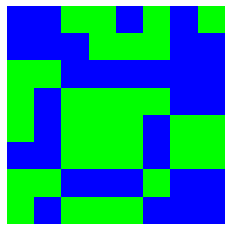

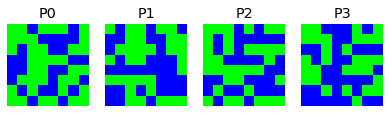

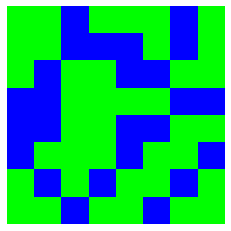

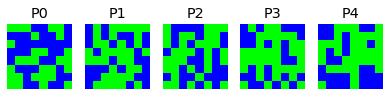

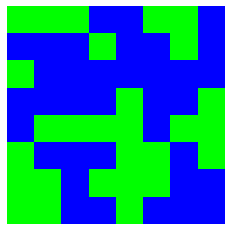

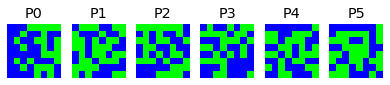

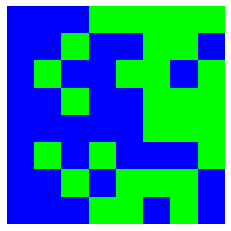

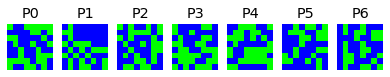

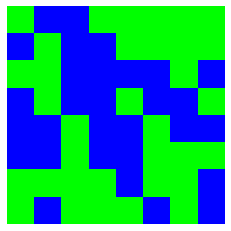

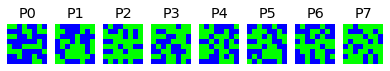

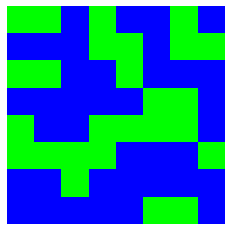

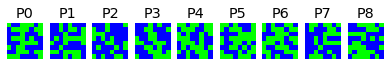

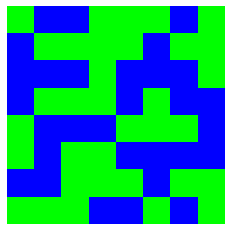

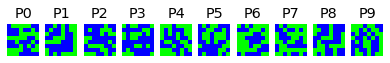

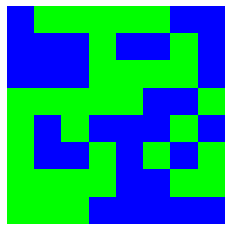

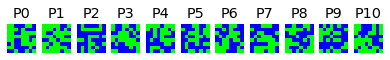

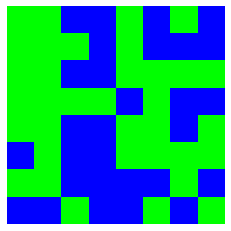

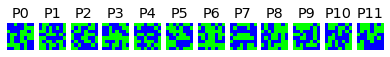

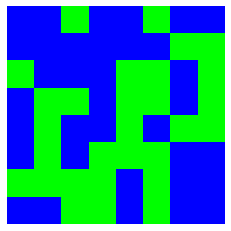

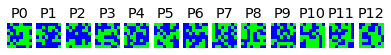

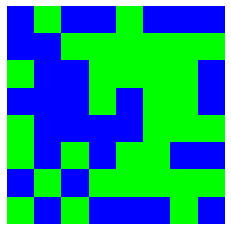

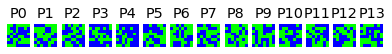

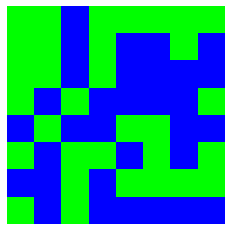

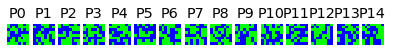

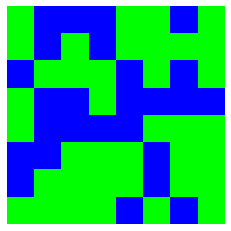

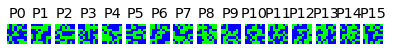

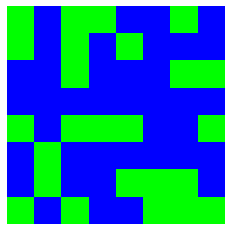

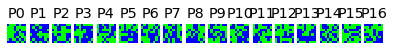

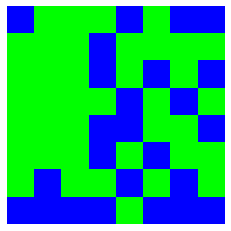

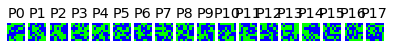

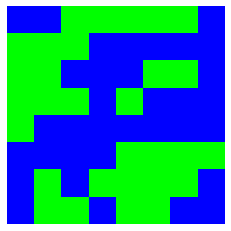

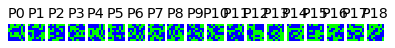

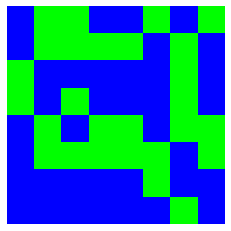

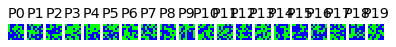

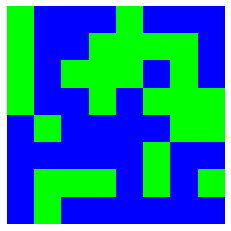

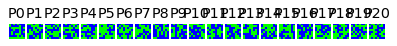

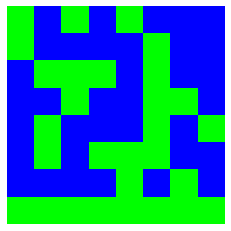

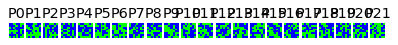

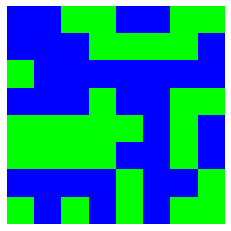

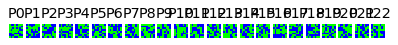

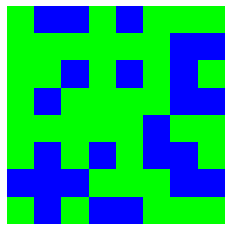

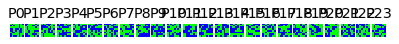

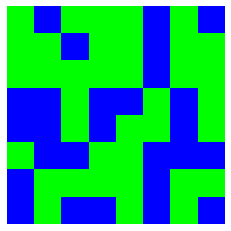

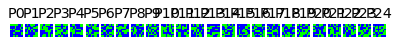

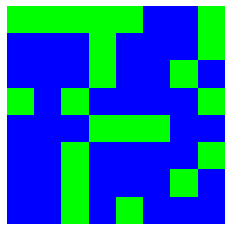

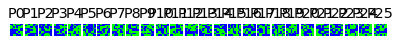

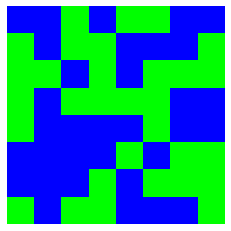

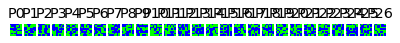

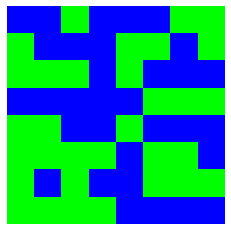

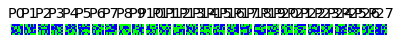

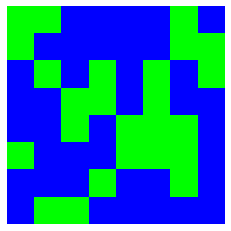

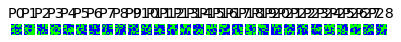

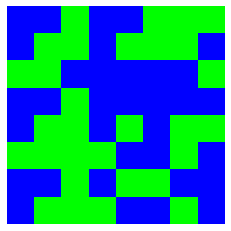

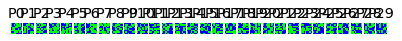

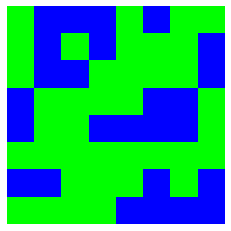

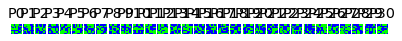

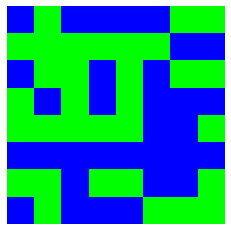

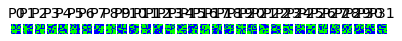

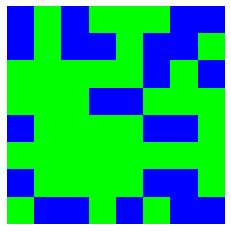

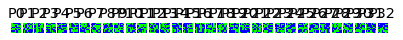

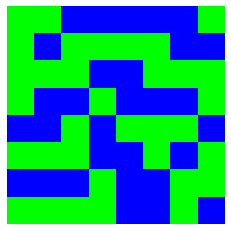

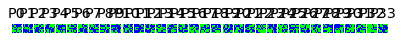

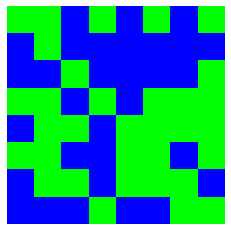

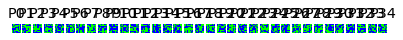

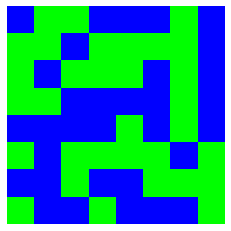

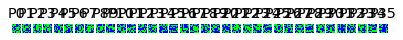

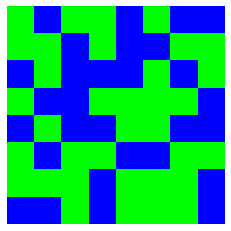

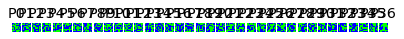

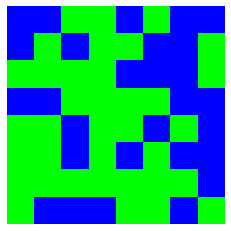

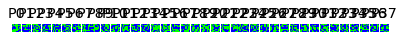

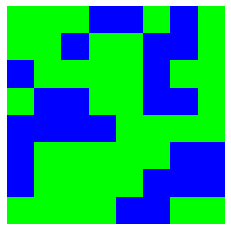

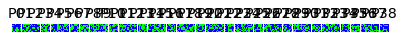

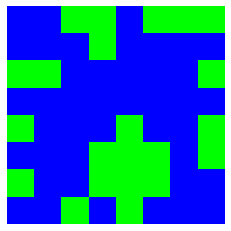

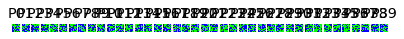

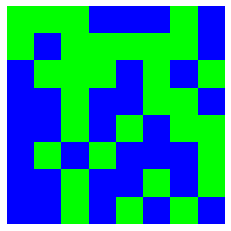

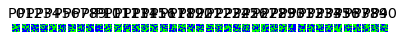

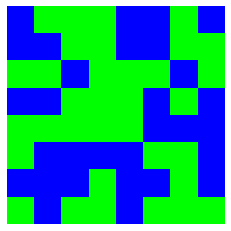

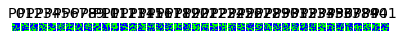

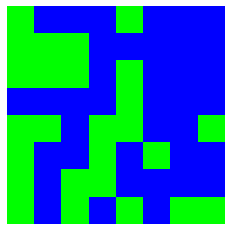

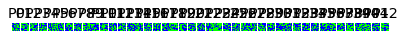

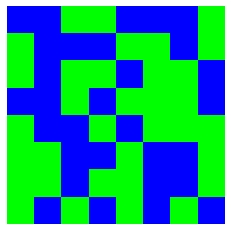

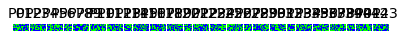

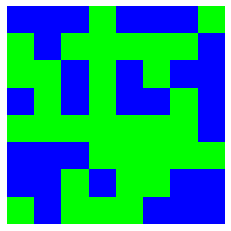

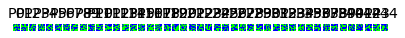

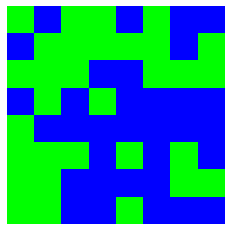

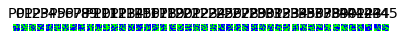

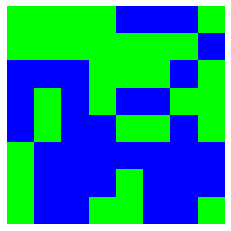

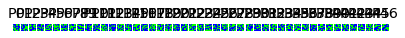

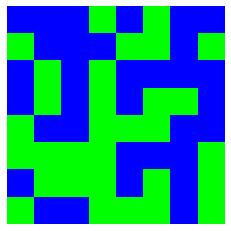

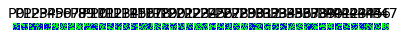

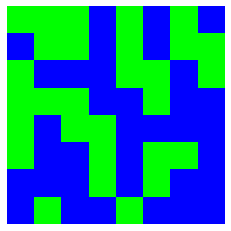

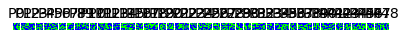

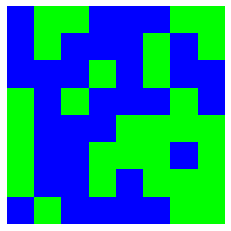

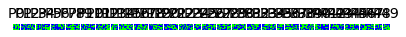

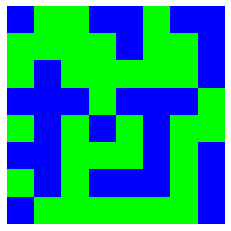

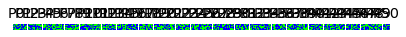

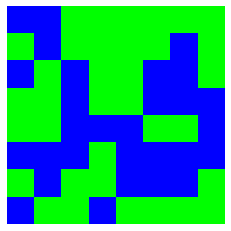

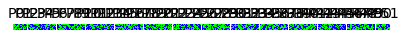

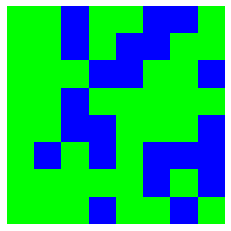

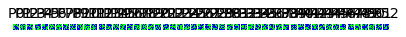

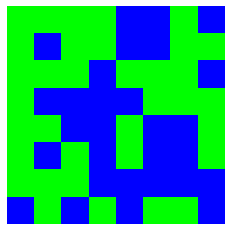

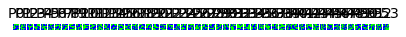

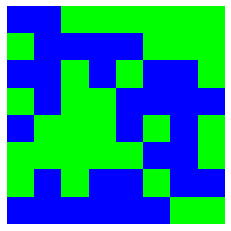

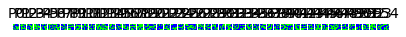

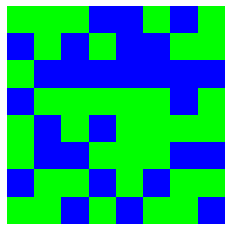

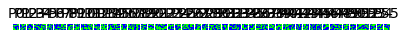

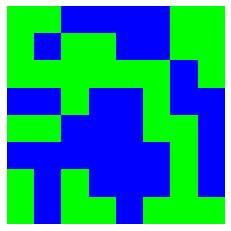

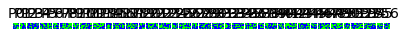

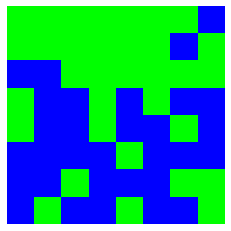

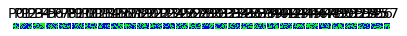

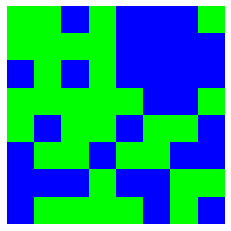

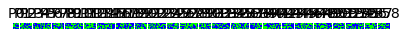

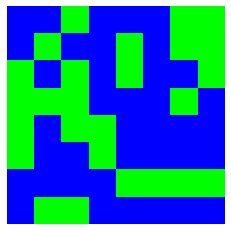

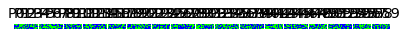

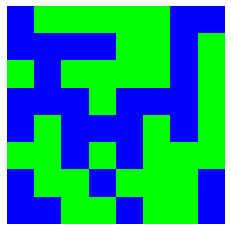

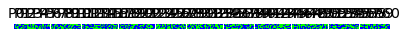

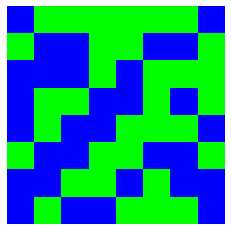

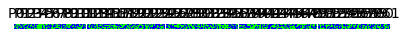

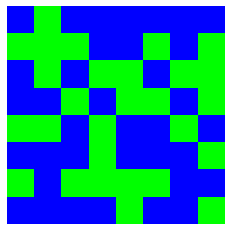

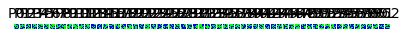

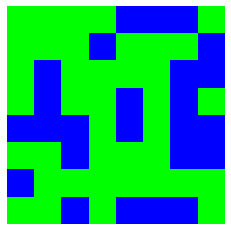

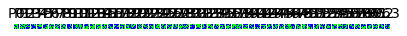

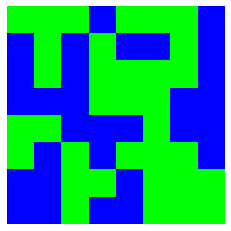

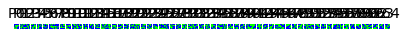

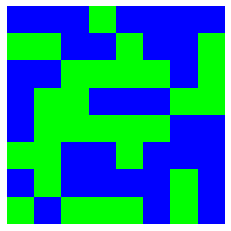

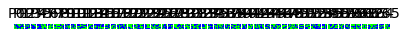

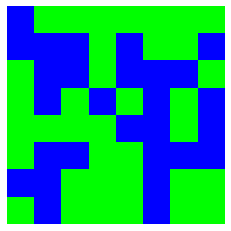

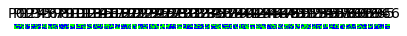

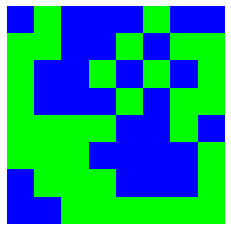

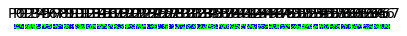

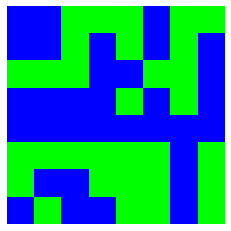

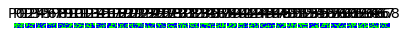

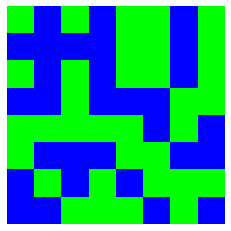

In [61]:
num_patterns_list=range(3,70)
overlap_corr=[]
for patt in num_patterns_list:
    overlap_corr.append(train_hopfield(8, patt, 5, 3, 0))

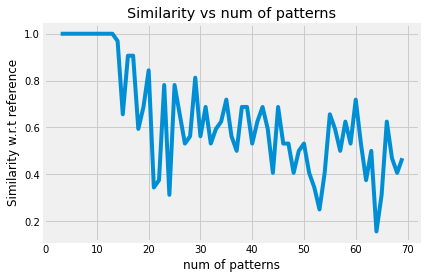

In [62]:
plt.plot(num_patterns_list, overlap_corr)
plt.xlabel('num of patterns')
plt.ylabel('Similarity w.r.t reference')
plt.title('Similarity vs num of patterns')
plt.show()

### Conclusion drawn

Over a long term horizon, if we keep on plotting the above graph for a bigger range we can identify a downward trend as increasing the number of patterns, while keeping the size of the network unchanged restricts the memory capacity of the network while increasing the data load to be stored, greatly impacting the potential performance(in terms of the overlap with the ref pattern) that the network can achieve.



### Size of the network


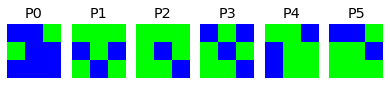

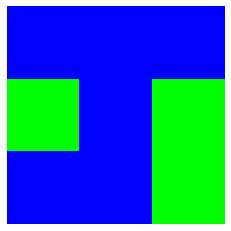

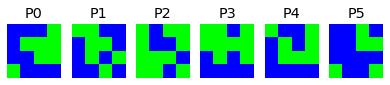

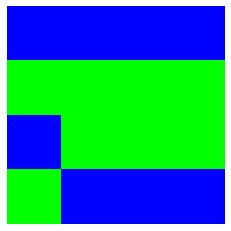

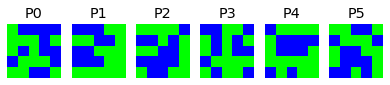

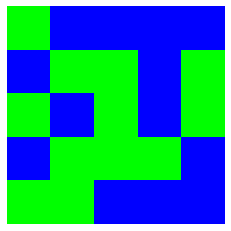

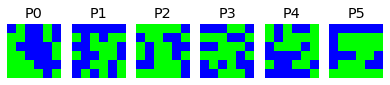

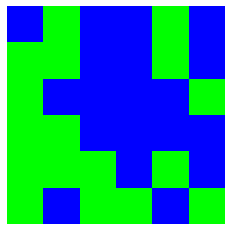

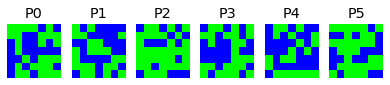

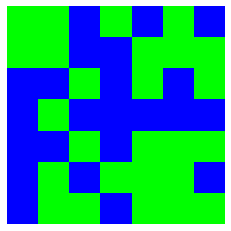

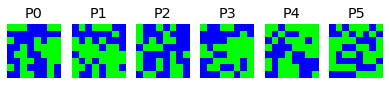

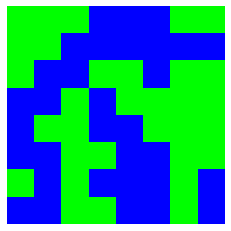

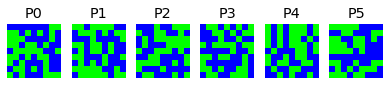

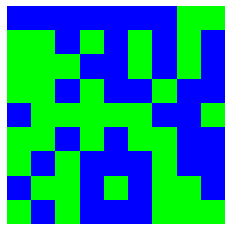

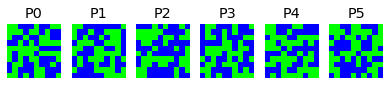

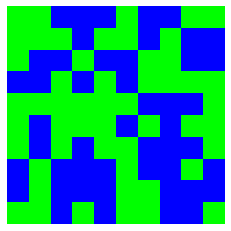

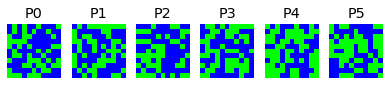

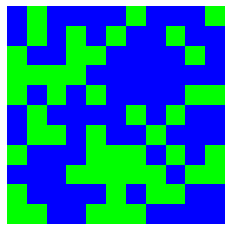

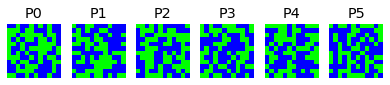

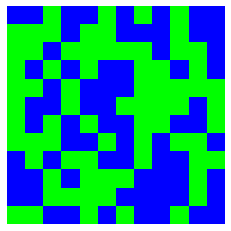

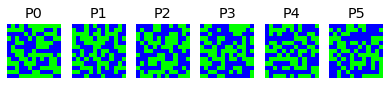

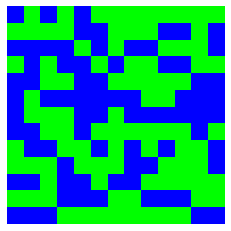

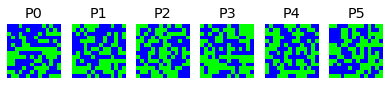

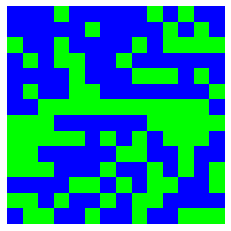

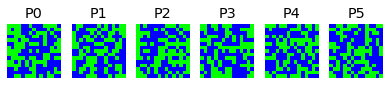

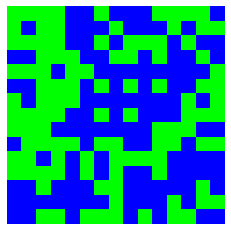

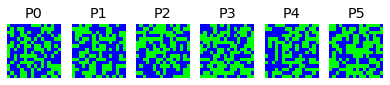

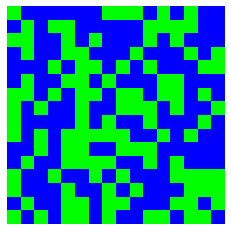

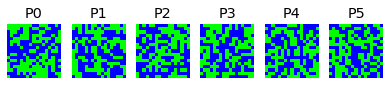

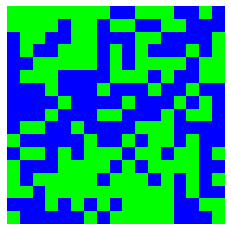

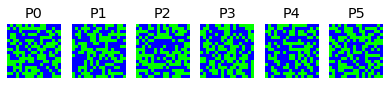

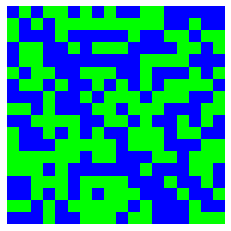

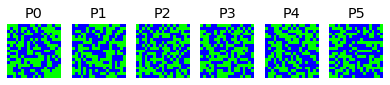

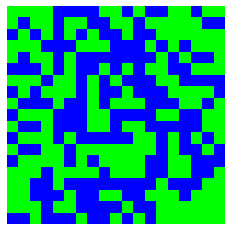

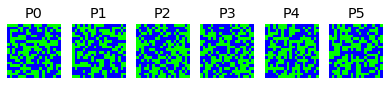

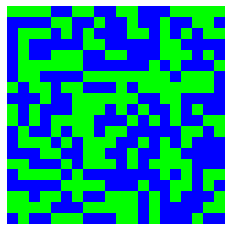

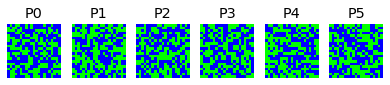

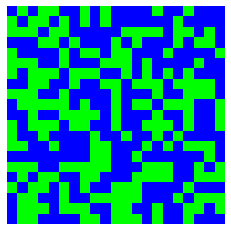

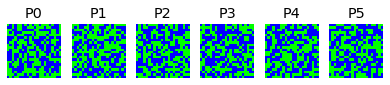

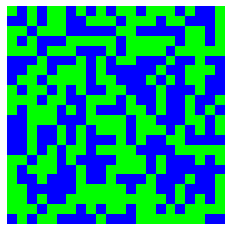

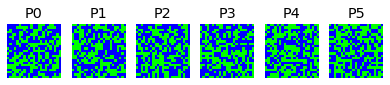

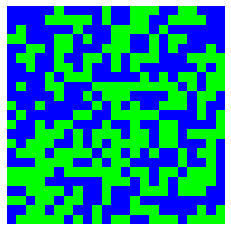

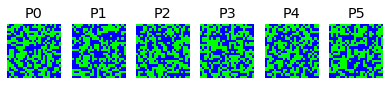

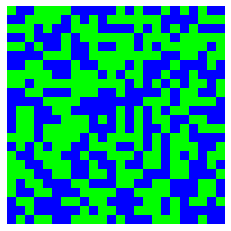

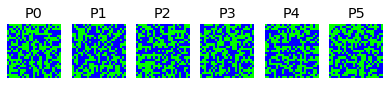

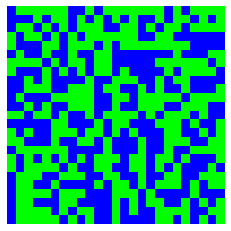

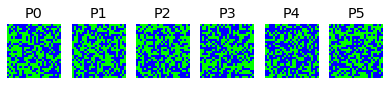

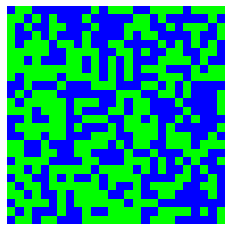

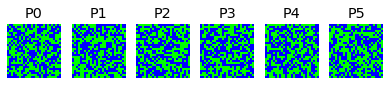

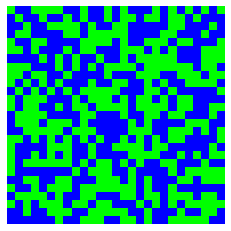

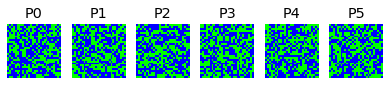

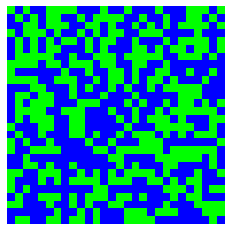

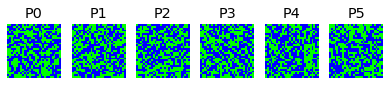

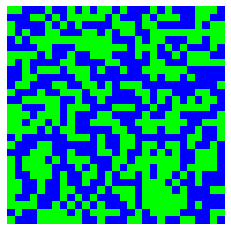

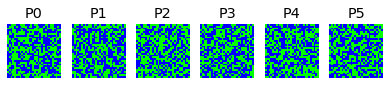

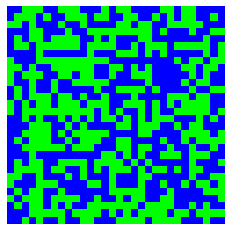

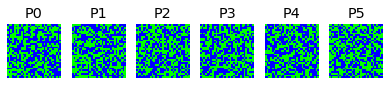

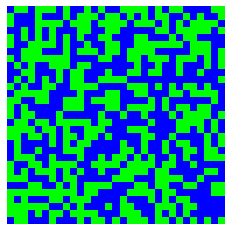

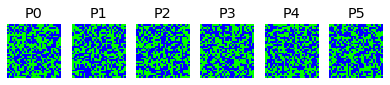

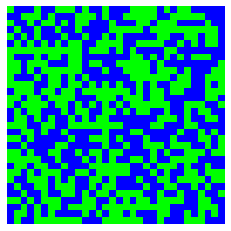

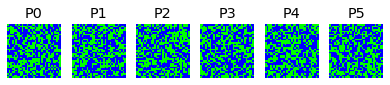

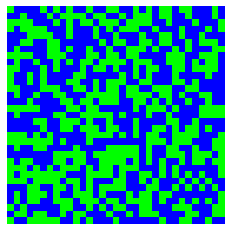

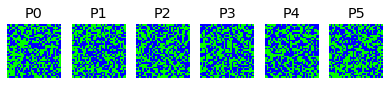

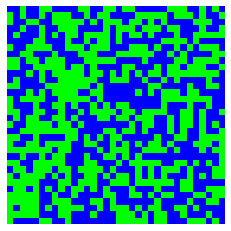

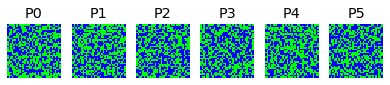

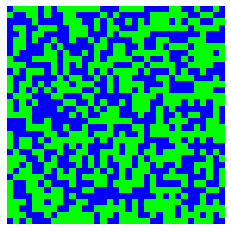

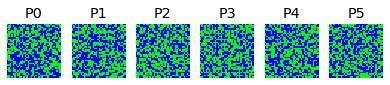

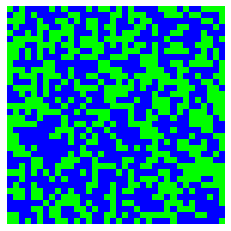

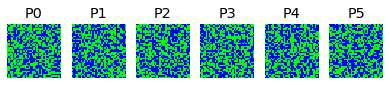

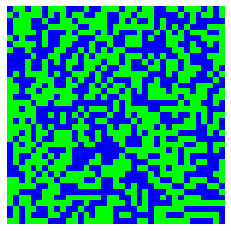

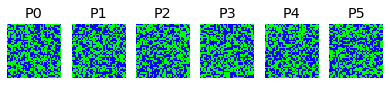

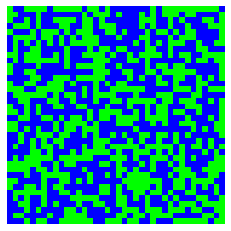

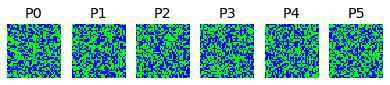

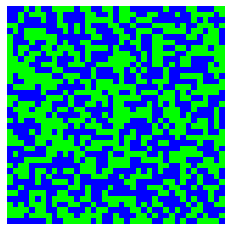

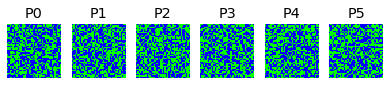

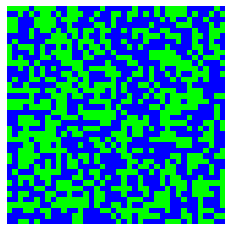

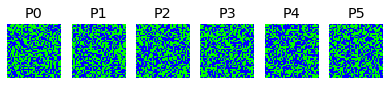

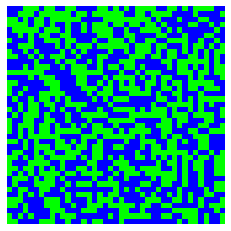

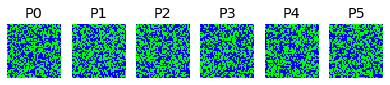

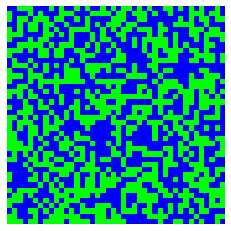

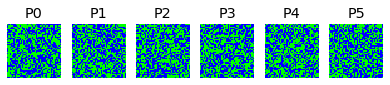

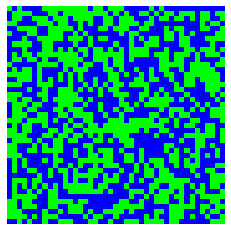

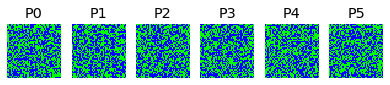

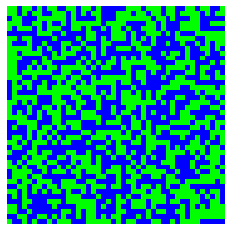

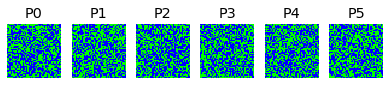

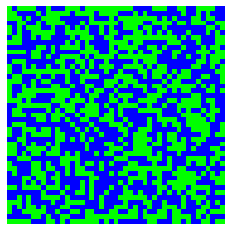

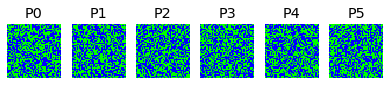

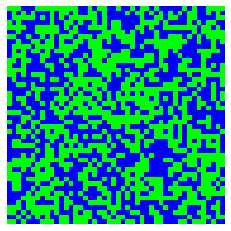

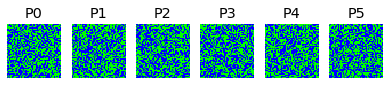

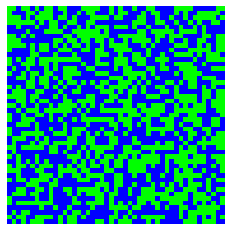

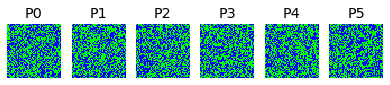

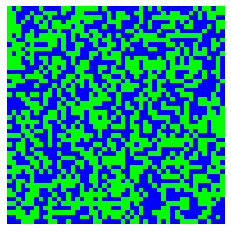

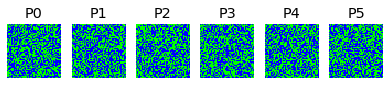

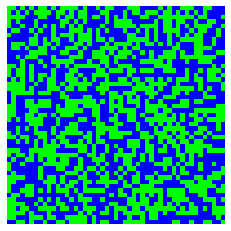

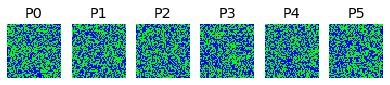

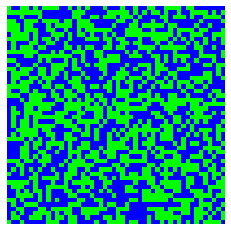

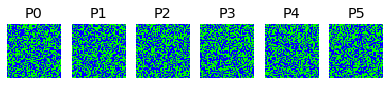

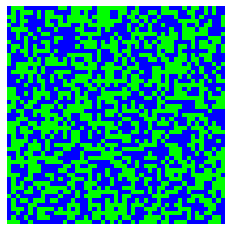

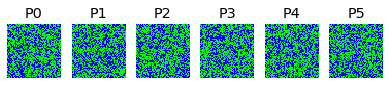

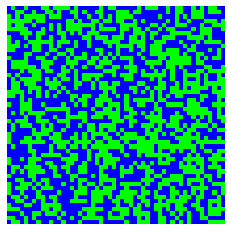

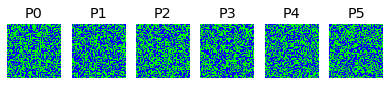

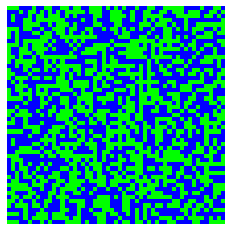

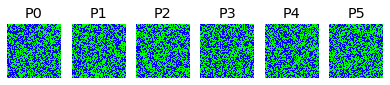

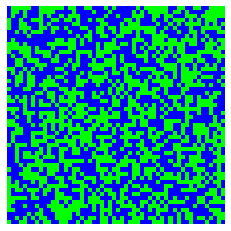

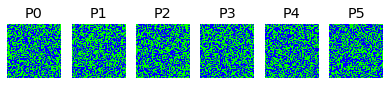

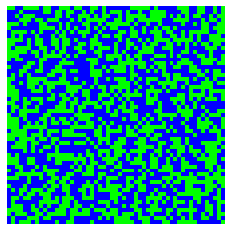

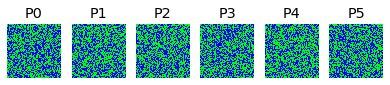

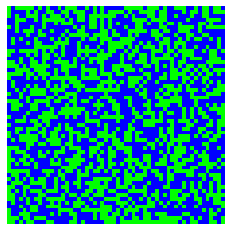

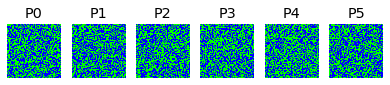

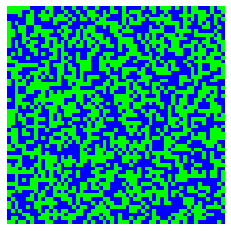

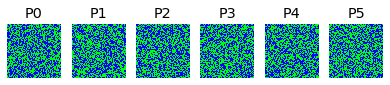

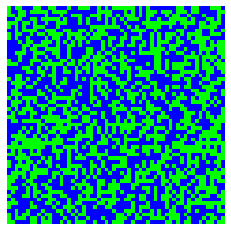

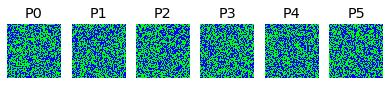

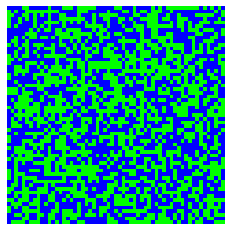

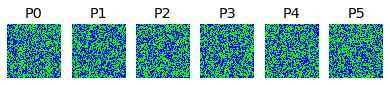

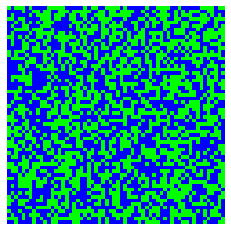

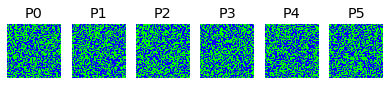

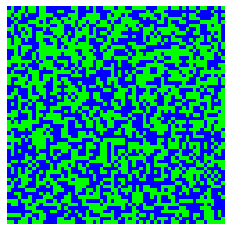

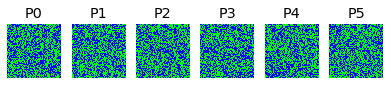

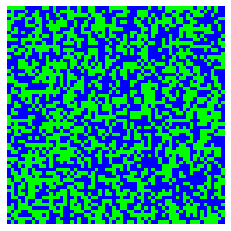

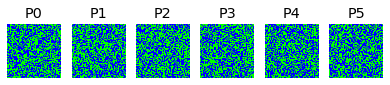

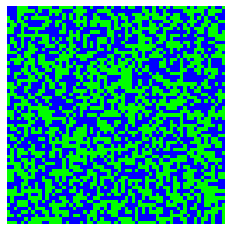

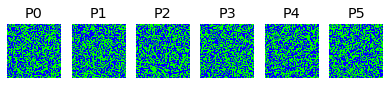

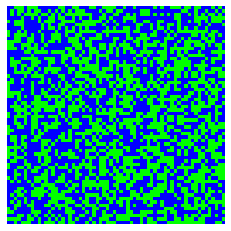

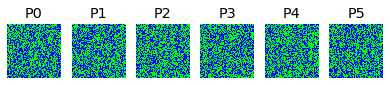

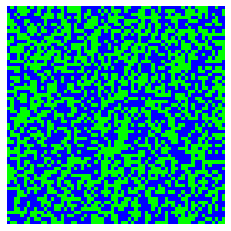

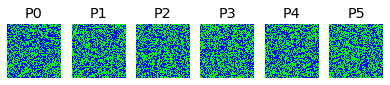

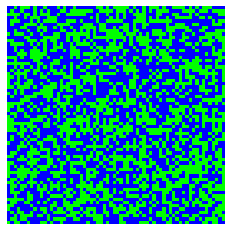

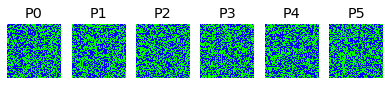

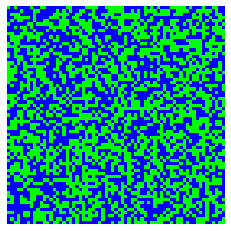

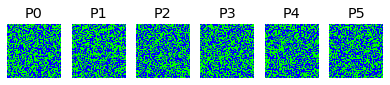

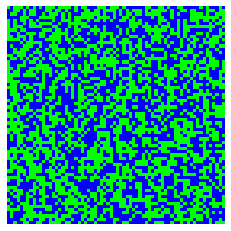

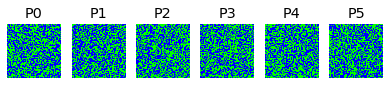

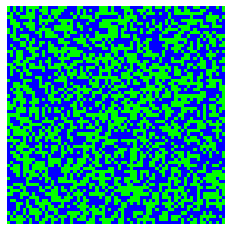

In [71]:
pattern_size_list=range(3,70)
overlap_corr=[]
for patt in pattern_size_list:
    overlap_corr.append(train_hopfield(patt, 6, 5, 3, 0))

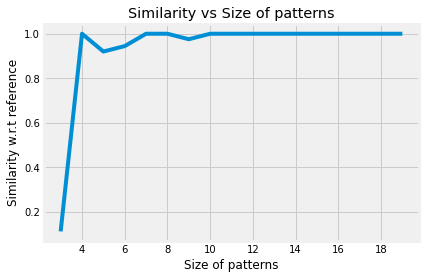

In [69]:
plt.plot(pattern_size_list, overlap_corr)
plt.xlabel('Size of patterns')
plt.ylabel('Similarity w.r.t reference')
plt.title('Similarity vs Size of patterns')
plt.show()

### Inference drawn from the above graph

As the no. of neurons increase(implicitly indicates increase in memory size), with increase in retaintivity the memory associations can be readily recalled with sufficient number of iterations, resulting in a significant overlap with the reference pattern.

## Preprocessing MNIST data and running hopfield on it

Presence of strong co
- Deskew all the images(both train and test)
- Crop all the images so the peripheral area around the digit gets reduced and the digits take on the centre stage

MNIST data in checkerboard form
(5, 28, 28)
(5, 28, 28)
(5, 28, 28)
(5, 28, 28)
(5, 28, 28)
(5, 28, 28)
(5, 28, 28)
(5, 28, 28)
(5, 28, 28)
(5, 28, 28)


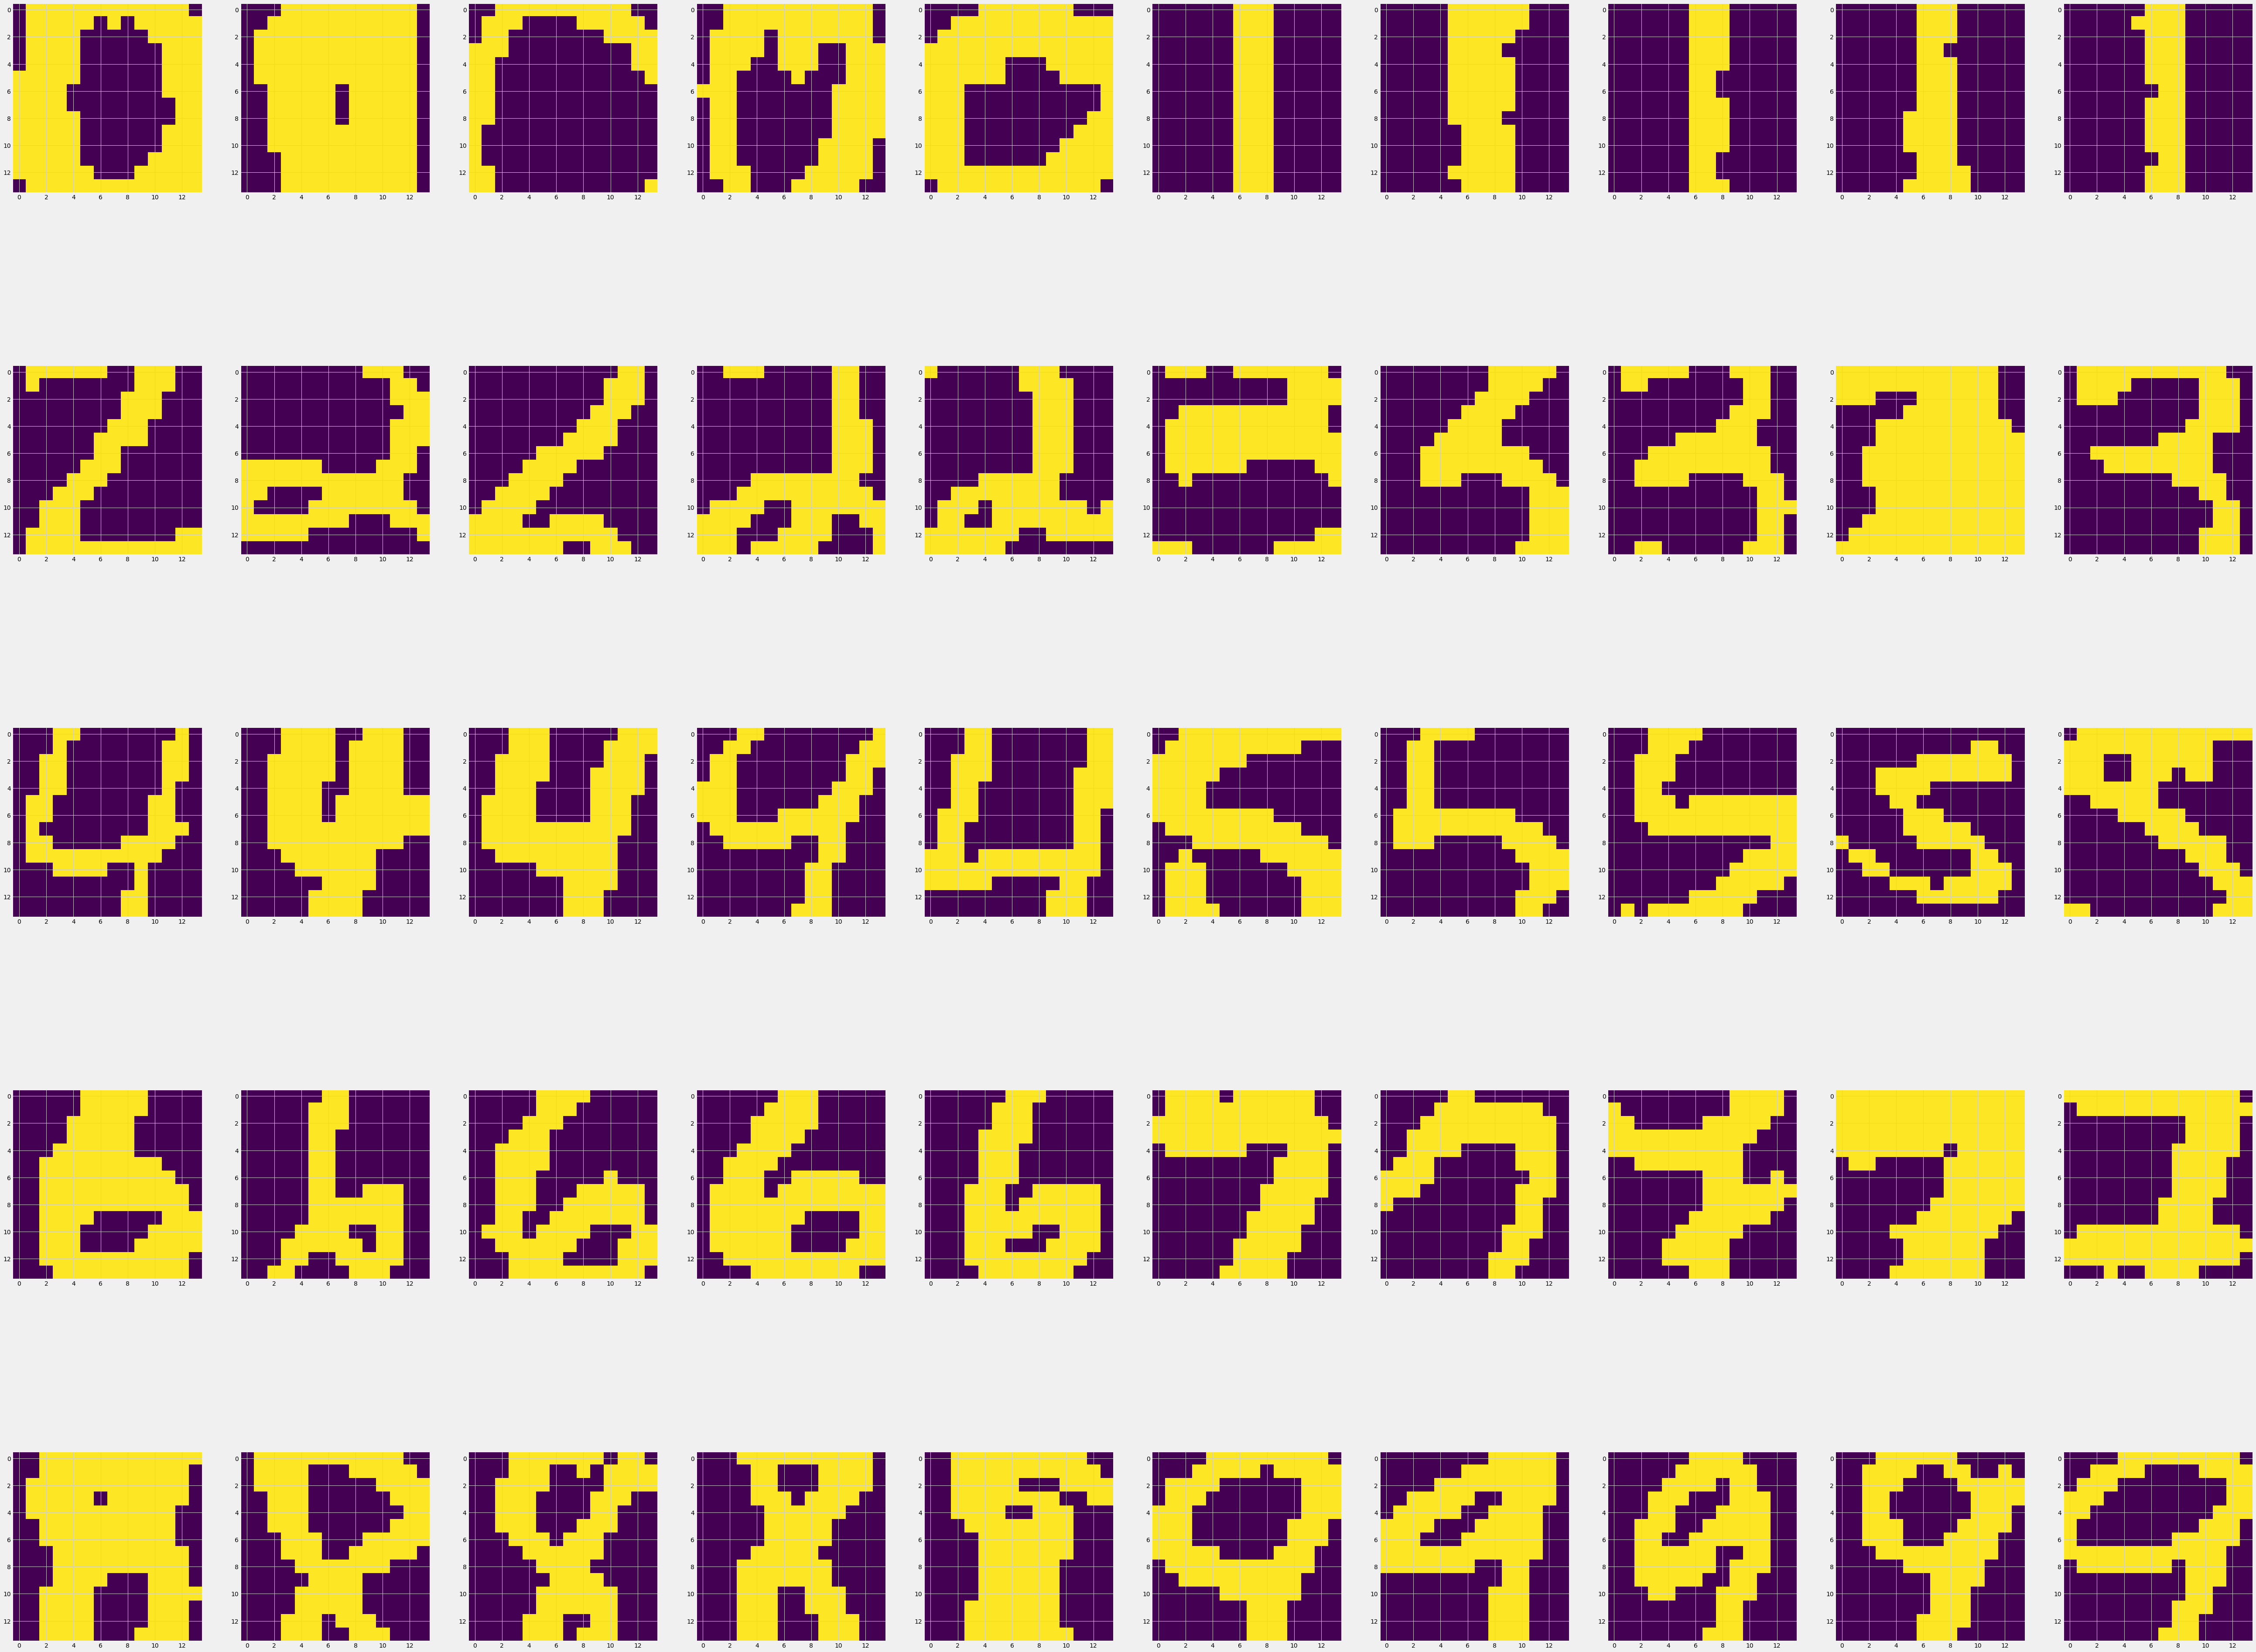

In [537]:
def moments(image):

    """
    Source: https://fsix.github.io/mnist/Deskewing.html
    """
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix

    return mu_vector, covariance_matrix

def deskew(image):
    
    """
    Source: https://fsix.github.io/mnist/Deskewing.html
    """
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)

    return interpolation.affine_transform(image,affine,offset=offset)


def pre_process(img,thresh, train=True):
#     print(img.shape)
#     length, breadth= img.shape

    if(train==True):
        im_tran=np.zeros((img.shape[0],14,14))
        
        for i in range(img.shape[0]):
            img[i]=deskew(img[i])
            im_tran[i]=img[i][7:21, 7:21]
    else:
        img=deskew(img)
        im_test=img[7:21, 7:21]
        
        return im_test
    
    #Converting Grayscale to B/W scale
   
    
    img_bw= (im_tran>=thresh) 
    
    #Converting 1,0 to +1,-1
    img_conv= 2*(img_bw)-1 # When img_bw pixel is 0 then the pixel value is -1, else 1
    
    #Reshaping image, which is a 2d matrix to a 1d vector by flattening it, as that'll be the number of pixels 
    neurons_act= np.reshape(img_conv, (img.shape[0],14*14))
    
    return neurons_act



(x_train, y_train)= mnist.train_images(),mnist.train_labels()
(x_test, y_test)= mnist.test_images(), mnist.test_labels()
# print(x_train.shape)

print("MNIST data in checkerboard form")



#training with pre-processing
data=[]
n_patterns=5
for i in range(10):


    indices=random.sample(list(np.nonzero(y_train==i)[0]),n_patterns)
    xi=np.take(x_train, indices, axis=0)
    print(xi.shape)
    data.append(pre_process(xi, 96))


data=np.array(data)
   
x_test_conv=[]

for i in range(x_test.shape[0]):
    x_test_conv.append(pre_process(x_test[i], 28, False))
    
x_test_conv=np.array(x_test_conv)
x_test_conv=np.reshape(x_test_conv, (-1,196))
data=np.array(data)
data=np.reshape(data, (-1,196))

fig=plt.figure(figsize=(82, 140))

for i in range(len(data)):
    img=data[i]
    fig.add_subplot(10, 10, i+1)
    plt.imshow(data[i].reshape(14,14))
    
plt.show()

In [81]:
data.shape

(40, 196)

In [533]:
W=calculate_weights(data, data.shape[1])
# W=calculate_weights(data, 1000)

In [534]:
np.unique(W)


array([-0.14285714, -0.13265306, -0.12244898, -0.1122449 , -0.10204082,
       -0.09183673, -0.08163265, -0.07142857, -0.06122449, -0.05102041,
       -0.04081633, -0.03061224, -0.02040816, -0.01020408,  0.        ,
        0.01020408,  0.02040816,  0.03061224,  0.04081633,  0.05102041,
        0.06122449,  0.07142857,  0.08163265,  0.09183673,  0.10204082,
        0.1122449 ,  0.12244898,  0.13265306,  0.14285714,  0.15306122,
        0.16326531,  0.17346939,  0.18367347,  0.19387755,  0.20408163,
        0.21428571,  0.2244898 ,  0.23469388])

In [ ]:
plist=deepcopy(x_train_conv)
plist=np.zeros((x_train.shape[0],28,28), dtype=int)
for i in range(6):
    plist[i]=x_test_conv[i].reshape(28,28)
    

    
np.sum(x_test_conv,axis=1)

In [535]:
#Predicted labels along rows, actual labels along cols
Confusion_matrix=np.zeros((10,10), dtype=int)
# np.random.seed(0)
rand_test_idx=np.random.choice(x_test_conv.shape[0],10000,replace=False)
pred_label=[]
actual_label=[]
for ind in rand_test_idx:
    
    S_old=x_test_conv[ind]
   
   
    for itr in range(1):
       
        S_new=network_evolution(deepcopy(S_old),W)
        S_old=S_new
    
   
    max_index=np.argmax(pattern_tools.compute_overlap_list(deepcopy(S_old), deepcopy(data)))
    
    pred_label.append(max_index//n_patterns)                       
   
    
    actual_label.append(y_test[ind])
#     print(pred_label,actual_label)
   
#     Confusion_matrix[pred_label][actual_label]+=1
    
    
conf=confusion_matrix(actual_label, pred_label)
print("",accuracy_score(actual_label, pred_label))

0.4197


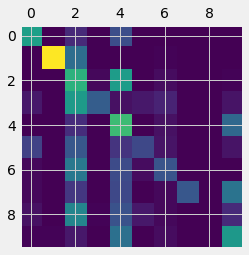

In [98]:
plt.matshow(conf)
plt.show()

In [191]:
# Confusion_matrix
Precision=Confusion_matrix[1][1]/(np.sum(Confusion_matrix[1][:]))

Recall=Confusion_matrix[1][1]/np.sum(Confusion_matrix[1][:])
                               
F1_score=(2*Precision*Recall)/(Precision+Recall)

#Classes are more or less balanced so we can go for Micro F1-score/ just vanilla F1 score
print("F1_score=",f1_score(actual_label, pred_label, average='micro')) 


F1_score= 0.4655


C:\Users\Jijo98\AppData\Local\Temp/ipykernel_10644/1698458204.py:2: RuntimeWarning: invalid value encountered in long_scalars
  Precision=Confusion_matrix[1][1]/(np.sum(Confusion_matrix[1][:]))
C:\Users\Jijo98\AppData\Local\Temp/ipykernel_10644/1698458204.py:4: RuntimeWarning: invalid value encountered in long_scalars
  Recall=Confusion_matrix[1][1]/np.sum(Confusion_matrix[1][:])


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009],
       dtype=int64))

## References

(The link provided below helped to understand the functions better)
- https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html

(Referred to the below link for understanding how hopfield works)
- https://www.youtube.com/watch?v=81B-ESqgCjs&t=1672s    